In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Circle
from mpl_toolkits.mplot3d import Axes3D


In [49]:
def calculate_curve_length(points):
    """Calculate the total length of a curve defined by points"""
    diff = np.diff(points, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    return np.sum(segment_lengths)

def resample_equidistant_points(points, num_points):
    """
    Resample points along a curve to be equidistant.
    
    Args:
        points: Original points along curve (N x 2 or N x 3 array)
        num_points: Number of equidistant points to generate
        
    Returns:
        Array of equidistant points along the curve
    """
    # Calculate cumulative distances along the curve
    diff = np.diff(points, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    cumulative_lengths = np.concatenate(([0], np.cumsum(segment_lengths)))
    total_length = cumulative_lengths[-1]
    
    print("TOTAL LENGTH:", total_length)
    
    # Create interpolation for each dimension
    splines = [
        CubicSpline(cumulative_lengths, points[:, i])
        for i in range(points.shape[1])
    ]
    
    # Generate equidistant points
    desired_distances = np.linspace(0, total_length, num_points)
    resampled_points = np.zeros((num_points, points.shape[1]))
    
    for i in range(points.shape[1]):
        resampled_points[:, i] = splines[i](desired_distances)
    
    return resampled_points

def normalize_angle(angle):
    """Normalize angle to [-pi, pi]"""
    return np.arctan2(np.sin(angle), np.cos(angle))

def normalize_angles(angles):
    """Normalize an array of angles to [-pi, pi]"""
    return np.array([normalize_angle(a) for a in angles])

def calculate_total_length(positions):
    """Calculate total length of the curve from discrete points"""
    diff = np.diff(positions, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    return np.sum(segment_lengths)

def scale_to_length(positions, target_length):
    """Scale the points to achieve a specific total length"""
    current_length = calculate_total_length(positions)
    scale_factor = target_length / current_length
    
    # Scale points around their centroid
    centroid = np.mean(positions, axis=0)
    scaled_positions = centroid + (positions - centroid) * scale_factor
    
    return scaled_positions

def calculate_yaw_from_tangent(tangent):
    """Calculate yaw angle from tangent vector, handling edge cases"""
    return np.arctan2(tangent[1], tangent[0])

def line_segment_distance(p1, p2, p3, p4):
    """
    Calculate the minimum distance between two line segments.
    p1, p2 define the first line segment
    p3, p4 define the second line segment
    """
    def dot(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def distance_point_to_segment(p, s1, s2):
        segment = s2 - s1
        length_sq = dot(segment, segment)
        if length_sq == 0:
            return np.linalg.norm(p - s1)
        t = max(0, min(1, dot(p - s1, segment) / length_sq))
        projection = s1 + t * segment
        return np.linalg.norm(p - projection)
    
    # Convert to numpy arrays for easier calculation
    p1 = np.array(p1[:2])  # Use only x,y coordinates
    p2 = np.array(p2[:2])
    p3 = np.array(p3[:2])
    p4 = np.array(p4[:2])
    
    # Calculate distances from each endpoint to the other segment
    d1 = distance_point_to_segment(p1, p3, p4)
    d2 = distance_point_to_segment(p2, p3, p4)
    d3 = distance_point_to_segment(p3, p1, p2)
    d4 = distance_point_to_segment(p4, p1, p2)
    
    return min(d1, d2, d3, d4)

def check_self_collision(positions, min_distance):
    """
    Check if any segments of the rope are too close to each other.
    Returns True if there is a collision, False otherwise.
    """
    n_segments = len(positions)
    
    # Check each pair of non-adjacent segments
    for i in range(n_segments - 2):
        for j in range(i + 2, n_segments-1):
            # Skip adjacent segments
            if abs(i - j) <= 1:
                continue
            
            # Calculate distance between segments
            dist = line_segment_distance(
                positions[i], positions[i+1],
                positions[j], positions[j+1]
            )
            
            # Check if distance is less than minimum allowed
            if dist < min_distance:
                return True
    return False

def compute_relative_quaternions(positions):
    """
    Compute relative quaternions between adjacent segments based on the direction to next point.
    Returns quaternions that represent the relative rotation from segment i to segment i+1.
    """
    num_segments = len(positions)
    relative_quaternions = np.zeros((num_segments, 4))  # (w, x, y, z) format
    
    # First find all direction vectors between consecutive points
    # Ensure positions is a numpy array
    positions = np.array(positions)
    
    # Calculate directions only for x,y components
    directions = np.zeros((num_segments, 2))
    directions[:-1] = positions[1:, :2] - positions[:-1, :2]  # Only use x,y coordinates
    directions[-1] = directions[-2]  # Last direction same as second-to-last
    
    # Normalize directions
    norms = np.sqrt(np.sum(directions * directions, axis=1))
    norms[norms == 0] = 1  # Avoid division by zero
    directions = directions / norms[:, np.newaxis]
    
    # Calculate yaw angles from directions
    absolute_yaws = np.arctan2(directions[:, 1], directions[:, 0])
    
    # First quaternion represents rotation from world frame to first direction
    first_rotation = Rotation.from_euler('z', absolute_yaws[0])
    quat = first_rotation.as_quat()  # (x, y, z, w) format
    relative_quaternions[0] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    # For remaining points, calculate relative rotation from previous direction to current
    for i in range(1, num_segments):
        # Calculate relative yaw (difference between consecutive absolute yaws)
        delta_yaw = normalize_angle(absolute_yaws[i] - absolute_yaws[i-1])
        
        # Convert to quaternion (rotation around Z axis)
        rotation = Rotation.from_euler('z', delta_yaw)
        quat = rotation.as_quat()  # (x, y, z, w) format
        relative_quaternions[i] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    return relative_quaternions

def generate_2d_rope_configuration(
    num_segments=28,
    workspace_bounds=np.array([[-0.5, 0.5], [-0.5, 0.5]]),
    num_control_points=5,
    z_height=0.1,
    noise_scale=0.02,
    max_delta_yaw=np.pi/4,
    min_segment_distance=0.05,
    max_attempts=100,
    curve_resolution=200,
    total_length=0.3
):
    """Generate random rope configuration with corrected orientations."""
    
    def smooth_angles(angles, max_delta):
        """Apply iterative smoothing to ensure max angle delta is respected"""
        smoothed = angles.copy()
        while True:
            original = smoothed.copy()
            
            # Forward pass
            for i in range(1, len(smoothed)):
                # Calculate delta in a way that respects angle wrapping
                delta = normalize_angle(smoothed[i] - smoothed[i-1])
                if abs(delta) > max_delta:
                    smoothed[i] = normalize_angle(smoothed[i-1] + np.sign(delta) * max_delta)
            
            # Backward pass
            for i in range(len(smoothed)-2, -1, -1):
                delta = normalize_angle(smoothed[i] - smoothed[i+1])
                if abs(delta) > max_delta:
                    smoothed[i] = normalize_angle(smoothed[i+1] + np.sign(delta) * max_delta)
            
            if np.allclose(original, smoothed, atol=1e-6):
                break
                
        return smoothed

    for attempt in range(max_attempts):
        # Generate random control points with increasing spread
        control_points = np.zeros((num_control_points, 2))
        spread_scale = np.linspace(0.3, 1.0, num_control_points)
        
        for i in range(2):
            bounds_range = workspace_bounds[i, 1] - workspace_bounds[i, 0]
            control_points[:, i] = workspace_bounds[i, 0] + bounds_range * (
                0.5 + spread_scale * np.random.uniform(-0.5, 0.5, num_control_points)
            )
        
        # Generate initial curve with high resolution
        t_dense = np.linspace(0, 1, curve_resolution)
        splines = [
            CubicSpline(np.linspace(0, 1, num_control_points), control_points[:, i])
            for i in range(2)
        ]
        
        # Sample dense points along the curve
        dense_points = np.zeros((curve_resolution, 2))
        for i in range(2):
            dense_points[:, i] = splines[i](t_dense)
            
        dense_points = scale_to_length(dense_points, total_length)
        
        # Resample to get equidistant points
        positions_2d = resample_equidistant_points(dense_points, num_segments)
        
        # Add Z coordinate
        positions = np.zeros((num_segments, 3))
        positions[:, :2] = positions_2d
        positions[:, 2] = z_height
        
        # Calculate tangent vectors using finite differences
        tangents = np.zeros((num_segments, 2))
        tangents[:-1] = np.diff(positions_2d, axis=0)
        tangents[-1] = tangents[-2]  # Use last valid tangent for final point
        
        # Normalize tangents
        norms = np.sqrt(np.sum(tangents * tangents, axis=1))
        tangents = tangents / norms[:, np.newaxis]
        
        # Calculate yaw angles from tangents with proper normalization
        yaw_angles = np.array([calculate_yaw_from_tangent(t) for t in tangents])
        yaw_angles = normalize_angles(yaw_angles)
        
        # Smooth the angles to satisfy max_delta constraint
        smoothed_yaws = smooth_angles(yaw_angles, max_delta_yaw)
        
        # Check constraints
        if not check_self_collision(positions, min_segment_distance):
            # Compute relative quaternions based on positions
            relative_quaternions = compute_relative_quaternions(positions)
            
            # Verify the relative rotations
            relative_yaws = np.array([
                2 * np.arccos(np.clip(quat[0], -1, 1)) for quat in relative_quaternions
            ])
            
            if np.all(relative_yaws <= max_delta_yaw + 1e-6):
                segment_distances = np.sqrt(np.sum(np.diff(positions, axis=0)**2, axis=1))
                total_length_achieved = np.sum(segment_distances)
                
                # Compute cumulative yaw for verification
                cumulative_yaw = np.zeros(num_segments)
                for i in range(1, num_segments):
                    w, x, y, z = relative_quaternions[i]
                    relative_yaw = 2 * np.arctan2(z, w)
                    cumulative_yaw[i] = cumulative_yaw[i-1] + relative_yaw
                
                return positions, relative_quaternions, smoothed_yaws
            
    raise ValueError(f"Failed to generate valid configuration after {max_attempts} attempts")


In [50]:
%matplotlib widget
def compute_absolute_quaternions(relative_quaternions):
    """
    Convert relative quaternions to absolute quaternions by accumulating rotations.
    """
    num_segments = len(relative_quaternions)
    absolute_quaternions = np.zeros_like(relative_quaternions)
    absolute_quaternions[0] = relative_quaternions[0]  # First quaternion is already in world frame
    
    # Accumulate rotations
    current_rotation = Rotation.from_quat([
        relative_quaternions[0, 1],  # x
        relative_quaternions[0, 2],  # y
        relative_quaternions[0, 3],  # z
        relative_quaternions[0, 0]   # w
    ])
    
    for i in range(1, num_segments):
        # Get the relative rotation for this segment
        relative_rotation = Rotation.from_quat([
            relative_quaternions[i, 1],  # x
            relative_quaternions[i, 2],  # y
            relative_quaternions[i, 3],  # z
            relative_quaternions[i, 0]   # w
        ])
        
        # Compose with previous rotation
        current_rotation = current_rotation * relative_rotation
        
        # Convert back to quaternion and store
        quat = current_rotation.as_quat()  # Returns (x, y, z, w)
        absolute_quaternions[i] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    return absolute_quaternions

def visualize_rope_configuration(positions, relative_quaternions, segment_length=0.05, min_segment_distance=0.05):
    """
    Visualize rope configuration with corrected orientation arrows, using relative quaternions.
    """
    # Convert relative quaternions to absolute for visualization
    absolute_quaternions = compute_absolute_quaternions(relative_quaternions)
    
    fig = plt.figure(figsize=(15, 6))
    
    # Create subplots: top view (2D) and perspective view (3D)
    ax1 = fig.add_subplot(121)  # 2D view
    ax2 = fig.add_subplot(122, projection='3d')  # 3D view
    
    # Plot 2D view (top-down)
    ax1.set_title('Top View (X-Y Plane)')
    
    # Plot positions and connection lines
    ax1.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.5, label='Rope Path')
    ax1.scatter(positions[:, 0], positions[:, 1], c='blue', s=30)
    
    # Plot orientation arrows
    for i, (pos, quat) in enumerate(zip(positions, absolute_quaternions)):
        # Convert quaternion to rotation matrix using scipy
        rotation = Rotation.from_quat([quat[1], quat[2], quat[3], quat[0]])  # Convert to scipy's format
        # Get the x-axis direction after rotation
        direction = rotation.apply([1, 0, 0])[:2]  # Take only x,y components
        
        # Create arrow for orientation
        ax1.arrow(
            pos[0], pos[1],
            direction[0] * segment_length,
            direction[1] * segment_length,
            head_width=0.02,
            head_length=0.02,
            fc='red',
            ec='red'
        )
        
        # Draw collision boundary circle
        if i % 3 == 0:  # Draw every third circle to avoid clutter
            circle = Circle(
                (pos[0], pos[1]),
                min_segment_distance/2,
                fill=False,
                linestyle='--',
                color='gray',
                alpha=0.3
            )
            ax1.add_patch(circle)
    
    # Set equal aspect ratio and grid
    ax1.set_aspect('equal')
    ax1.grid(True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # Plot 3D view
    ax2.set_title('Perspective View')
    
    # Plot positions and connection lines
    ax2.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', alpha=0.5)
    ax2.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=30)
    
    # Plot orientation arrows in 3D
    for pos, quat in zip(positions, absolute_quaternions):
        rotation = Rotation.from_quat([quat[1], quat[2], quat[3], quat[0]])
        direction = rotation.apply([1, 0, 0])
        
        ax2.quiver(
            pos[0], pos[1], pos[2],
            direction[0] * segment_length,
            direction[1] * segment_length,
            direction[2] * segment_length,
            color='red',
            alpha=0.6
        )
    
    # # Add visualization of relative rotations
    # ax3 = fig.add_subplot(223)
    # ax3.set_title('Relative Yaw Angles')
    
    # # Extract relative yaw angles
    # relative_yaws = np.array([
    #     2 * np.arctan2(quat[3], quat[0])  # z and w components for yaw
    #     for quat in relative_quaternions
    # ])
    
    # ax3.plot(relative_yaws * 180/np.pi, 'g-', label='Relative Yaw')
    # ax3.set_xlabel('Segment Index')
    # ax3.set_ylabel('Relative Yaw (degrees)')
    # ax3.grid(True)
    # ax3.legend()
    
    plt.tight_layout()
    plt.show()

TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.2896551799999996
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.28965517999999946
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.28965518
TOTAL LENGTH: 0.28965518000000023
TOTAL LENGTH: 0.2896551800000001
TOTAL LENGTH: 0.28965517999999973
TOTAL LENGTH: 0.28965518000000057
TOTAL LENGTH: 0.28965517999999996
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.28965517999999996
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000001
TOTAL LENGTH: 0.2896551800000012
TOTAL LENGTH: 0.28965518
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.2896551800000005
TOTAL LENGTH: 0.28965518000000035
TOTAL LENGTH: 0.2896551800000007
TOTAL LENGTH: 0.2896551799999999
TOTAL LENGTH: 0.2896551799999997
TOTAL LENGTH: 0.28965518000000073
TOTAL LENGTH: 0.2896551799999999
TOTAL LENGTH: 0.28965518000000007
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH:

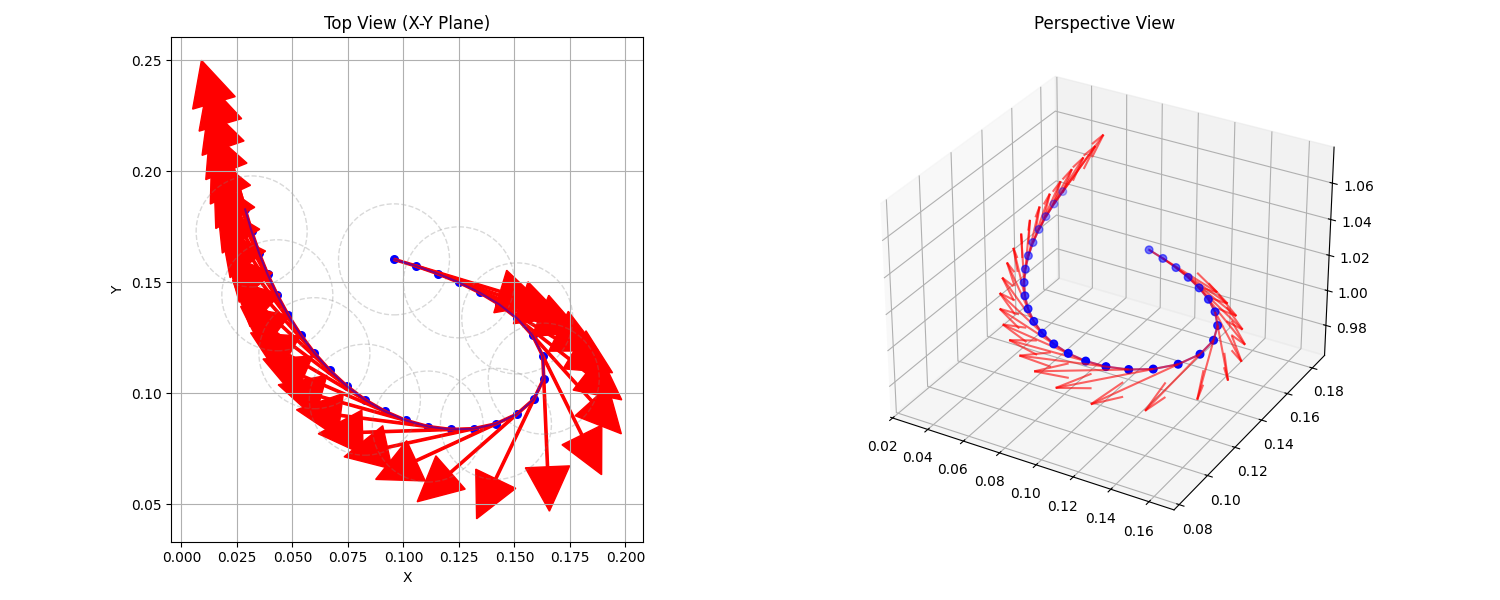

Configuration Statistics:
Z-height mean: 1.021000
Z-height std: 0.000000
Number of segments: 29

Quaternion Statistics:
Mean absolute X component: 0.0
Mean absolute Y component: 0.0


In [51]:
# Generate a sample configuration
positions, quaternions, yaw_angles = generate_2d_rope_configuration(
    num_segments=29,
    workspace_bounds=np.array([(0.011, 0.24), (0.007, 0.27)]),
    z_height=1.021,
    num_control_points=4,
    max_delta_yaw=np.pi/6,
    min_segment_distance=0.01,
    max_attempts=1000,
    curve_resolution=2000,
    total_length=0.28965518
)

# Visualize it
visualize_rope_configuration(positions, quaternions)

# Print some statistics
print("Configuration Statistics:")
print(f"Z-height mean: {positions[:, 2].mean():.6f}")
print(f"Z-height std: {positions[:, 2].std():.6f}")
print(f"Number of segments: {len(positions)}")

# Verify quaternions are yaw-only (x and y component
# s should be ~0)
print("\nQuaternion Statistics:")
print("Mean absolute X component:", np.abs(quaternions[:, 1]).mean())
print("Mean absolute Y component:", np.abs(quaternions[:, 2]).mean())

In [52]:
for i in range(len(positions) - 1):
    a = positions[i]
    b = positions[i + 1]
    print(f"Distance between {i} and {i + 1}: {np.linalg.norm(a - b):.6f}")

Distance between 0 and 1: 0.010344
Distance between 1 and 2: 0.010344
Distance between 2 and 3: 0.010343
Distance between 3 and 4: 0.010342
Distance between 4 and 5: 0.010341
Distance between 5 and 6: 0.010336
Distance between 6 and 7: 0.010325
Distance between 7 and 8: 0.010294
Distance between 8 and 9: 0.010244
Distance between 9 and 10: 0.010251
Distance between 10 and 11: 0.010295
Distance between 11 and 12: 0.010319
Distance between 12 and 13: 0.010328
Distance between 13 and 14: 0.010333
Distance between 14 and 15: 0.010335
Distance between 15 and 16: 0.010336
Distance between 16 and 17: 0.010338
Distance between 17 and 18: 0.010339
Distance between 18 and 19: 0.010340
Distance between 19 and 20: 0.010341
Distance between 20 and 21: 0.010341
Distance between 21 and 22: 0.010342
Distance between 22 and 23: 0.010343
Distance between 23 and 24: 0.010343
Distance between 24 and 25: 0.010343
Distance between 25 and 26: 0.010344
Distance between 26 and 27: 0.010344
Distance between 27 

In [9]:
import numpy as np
import cv2
import time

# Create sample masks (1920x1080)
mask1 = np.random.randint(0, 2, (1080, 1920, 3), dtype=np.uint8)
mask2 = np.random.randint(0, 2, (1080, 1920), dtype=np.uint8)

# Test multiplication
# start = time.time()
# for _ in range(1000):
#     result = mask1 * mask2
# print(f"Multiplication: {time.time() - start:.4f}s")

# Test cv2.bitwise_and
start = time.time()
for _ in range(1000):
    result = cv2.bitwise_and(mask1, mask1, mask = mask2)
print(f"OpenCV bitwise_and: {time.time() - start:.4f}s")

# Test logical_and
start = time.time()
for _ in range(1000):
    result = np.logical_and(mask1, np.expand_dims(mask2, -1))
print(f"Logical AND: {time.time() - start:.4f}s")


OpenCV bitwise_and: 0.9169s
Logical AND: 8.1462s


In [11]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import time
from typing import Tuple, List
import matplotlib.pyplot as plt

def sample_boundary_points_vectorized(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    """Vectorized boundary sampling implementation"""
    diffs = np.diff(boundary_points, axis=0)
    segment_lengths = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate(([0], np.cumsum(segment_lengths)))
    cumulative_dist = cumulative_dist / cumulative_dist[-1]
    
    fx = interp1d(cumulative_dist, boundary_points[:, 0], kind='cubic')
    fy = interp1d(cumulative_dist, boundary_points[:, 1], kind='cubic')
    
    t = np.linspace(0, 1, n_samples)
    return np.column_stack([fx(t), fy(t)])

def kmeans_boundary_sampling(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    """KMeans-based boundary sampling"""
    kmeans = KMeans(n_clusters=n_samples, n_init=1, max_iter=100)
    kmeans.fit(boundary_points)
    return kmeans.cluster_centers_

def benchmark_methods(sizes: List[int], n_samples: List[int], n_runs: int = 5) -> Tuple[dict, dict]:
    """Benchmark both methods for different input sizes and sample counts"""
    interpolation_times = {}
    kmeans_times = {}
    
    for size in sizes:
        # Generate test data (complex shape)
        t = np.linspace(0, 4*np.pi, size)
        boundary_points = np.column_stack([
            t*np.cos(t)/10,  # Spiral-like shape
            t*np.sin(t)/10
        ])
        
        for n in n_samples:
            key = f"size_{size}_samples_{n}"
            interpolation_times[key] = []
            kmeans_times[key] = []
            
            for _ in range(n_runs):
                # Time interpolation method
                start = time.perf_counter()
                _ = sample_boundary_points_vectorized(boundary_points, n)
                interpolation_times[key].append(time.perf_counter() - start)
                
                # Time kmeans method
                start = time.perf_counter()
                _ = kmeans_boundary_sampling(boundary_points, n)
                kmeans_times[key].append(time.perf_counter() - start)
    
    return interpolation_times, kmeans_times

# Run benchmark
sizes = [200, 500, 1000, 5000]
n_samples = [10, 50, 100, 200]
interp_times, kmeans_times = benchmark_methods(sizes, n_samples)

# Print results
print("\nAverage execution times (seconds):")
print("\nBoundary Points | Samples | Interpolation | K-means")
print("-" * 50)
for size in sizes:
    for n in n_samples:
        key = f"size_{size}_samples_{n}"
        avg_interp = np.mean(interp_times[key])
        avg_kmeans = np.mean(kmeans_times[key])
        print(f"{size:14d} | {n:7d} | {avg_interp:12.6f} | {avg_kmeans:.6f}")


Average execution times (seconds):

Boundary Points | Samples | Interpolation | K-means
--------------------------------------------------
           200 |      10 |     0.000508 | 0.001705
           200 |      50 |     0.000346 | 0.003958
           200 |     100 |     0.000364 | 0.006920
           200 |     200 |     0.000377 | 0.012427
           500 |      10 |     0.000467 | 0.004570
           500 |      50 |     0.000475 | 0.007416
           500 |     100 |     0.000495 | 0.010569
           500 |     200 |     0.000505 | 0.016950
          1000 |      10 |     0.000618 | 0.005044
          1000 |      50 |     0.000621 | 0.007652
          1000 |     100 |     0.000630 | 0.011455
          1000 |     200 |     0.000652 | 0.019060
          5000 |      10 |     0.002001 | 0.024993
          5000 |      50 |     0.002112 | 0.023659
          5000 |     100 |     0.002121 | 0.038886
          5000 |     200 |     0.002181 | 0.066731


In [16]:
import numpy as np
from scipy.spatial import ConvexHull, KDTree
import time
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Set, Dict
import pandas as pd

class TestEnvironment:
    def __init__(self, num_robots: int, world_size: float = 10.0):
        self.num_robots = num_robots
        self.world_size = world_size
        self.rb_pos_world = np.random.rand(num_robots, 8, 2) * world_size
        self.kdtree_positions_world = self.rb_pos_world.reshape(-1, 2)
    
    def expand_hull(self, hull: ConvexHull, world: bool = True) -> ConvexHull:
        return hull

def original_implementation(self, boundary_pts: np.ndarray) -> Tuple[Set[tuple], np.ndarray]:
    """Original implementation modified to return nearest neighbors"""
    hull = ConvexHull(boundary_pts)
    hull = self.expand_hull(hull, world=True)
    A, b = hull.equations[:, :-1], hull.equations[:, -1:]

    idxs = set()
    nearest_neighbors = []
    eps = np.finfo(np.float32).eps
    kdtree = KDTree(self.kdtree_positions_world)

    # Find nearest neighbors for boundary points
    distances, indices = kdtree.query(boundary_pts, k=3, distance_upper_bound=0.03, workers=8)
    indices = np.unique(indices[~np.isinf(distances)])
    unique_indices = np.unique(indices)
    pos_world = self.rb_pos_world[unique_indices // 8, unique_indices % 8]
    containment_check = np.all(pos_world @ A.T + b.T < eps, axis=1)

    # Create KDTree for boundary points
    boundary_kdtree = KDTree(boundary_pts)

    for idx, is_inside in zip(unique_indices, containment_check):
        if not is_inside:
            idxs.add((idx // 8, idx % 8))
            # Find nearest boundary point
            robot_pos = self.kdtree_positions_world[idx]
            _, nearest_idx = boundary_kdtree.query(robot_pos.reshape(1, -1), k=1)
            nearest_neighbors.append(boundary_pts[nearest_idx[0]])
        else:
            current_pos = self.kdtree_positions_world[idx]
            kdt_pos_copy = self.kdtree_positions_world.copy()
            mask = np.all(kdt_pos_copy @ A.T + b.T < eps, axis=1)
            kdt_pos_copy = kdt_pos_copy[~mask]
            if len(kdt_pos_copy) == 0:
                continue
            new_kdtree = KDTree(kdt_pos_copy)
            new_idx = new_kdtree.query(current_pos.reshape(1, -1))[1][0]
            new_pos = kdt_pos_copy[new_idx]
            new_idx = np.where((self.kdtree_positions_world == new_pos).all(axis=1))[0][0]
            idxs.add((new_idx // 8, new_idx % 8))
            # Find nearest boundary point for the outside point
            _, nearest_idx = boundary_kdtree.query(new_pos.reshape(1, -1), k=1)
            nearest_neighbors.append(boundary_pts[nearest_idx[0]])

    return idxs, np.array(nearest_neighbors)

def optimized_implementation(self, boundary_pts: np.ndarray) -> Tuple[Set[tuple], np.ndarray]:
    """Optimized implementation returning both indices and nearest neighbors"""
    hull = ConvexHull(boundary_pts)
    hull = self.expand_hull(hull, world=True)
    A, b = hull.equations[:, :-1], hull.equations[:, -1:]
    
    eps = np.finfo(np.float32).eps
    boundary_kdtree = KDTree(boundary_pts)
    
    idxs = set()
    nearest_neighbors = []
    
    # Vectorized containment check
    pos_world = self.rb_pos_world.reshape(-1, 2)
    containment = np.all(pos_world @ A.T + b.T < eps, axis=1)
    
    # Process points outside hull
    outside_mask = ~containment
    outside_indices = np.where(outside_mask)[0]
    
    if len(outside_indices) > 0:
        outside_positions = pos_world[outside_indices]
        # Find nearest boundary points for outside robots
        _, boundary_indices = boundary_kdtree.query(
            outside_positions, 
            k=1,
            workers=-1
        )
        
        for idx, bound_idx in zip(outside_indices, boundary_indices):
            row, col = idx // 8, idx % 8
            idxs.add((row, col))
            nearest_neighbors.append(boundary_pts[bound_idx])
    
    # Process points inside hull
    inside_indices = np.where(containment)[0]
    if len(inside_indices) > 0 and np.any(outside_mask):
        # Create KDTree for outside points
        outside_positions = pos_world[outside_mask]
        if len(outside_positions) > 0:
            outside_kdtree = KDTree(outside_positions)
            
            # Find nearest outside points for inside robots
            distances, outside_indices = outside_kdtree.query(
                pos_world[inside_indices],
                k=1,
                workers=-1
            )
            
            for idx, (dist, outside_idx) in enumerate(zip(distances, outside_indices)):
                if np.isinf(dist):
                    continue
                    
                robot_idx = inside_indices[idx]
                row, col = robot_idx // 8, robot_idx % 8
                outside_point = outside_positions[outside_idx]
                
                # Find nearest boundary point to the outside point
                _, bound_idx = boundary_kdtree.query(
                    outside_point.reshape(1, -1),
                    k=1,
                    workers=-1
                )
                
                idxs.add((row, col))
                nearest_neighbors.append(boundary_pts[bound_idx[0]])
    
    return idxs, np.array(nearest_neighbors)

def benchmark_implementation(impl: Callable, env: TestEnvironment, 
                           boundary_pts: np.ndarray, num_runs: int = 5) -> dict:
    """Benchmark a single implementation"""
    times = []
    for _ in range(num_runs):
        start_time = time.perf_counter()
        idxs, neighbors = impl(env, boundary_pts)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    
    return {
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'num_points': len(idxs)
    }

# Test correctness
def test_implementations(env: TestEnvironment, boundary_pts: np.ndarray):
    """Compare results between implementations"""
    orig_idxs, orig_nn = original_implementation(env, boundary_pts)
    opt_idxs, opt_nn = optimized_implementation(env, boundary_pts)
    
    print(f"\nNumber of points found:")
    print(f"Original: {len(orig_idxs)}")
    print(f"Optimized: {len(opt_idxs)}")
    
    # Compare point sets
    common_points = orig_idxs.intersection(opt_idxs)
    print(f"\nCommon points: {len(common_points)}")
    print(f"Points only in original: {len(orig_idxs - opt_idxs)}")
    print(f"Points only in optimized: {len(opt_idxs - orig_idxs)}")

# Run benchmarks
scenarios = [
    (64, 100),   # Small scenario
    # (500, 5000),   # Medium scenario
    # (1000, 10000)  # Large scenario
]

results = []
for num_robots, num_boundary_pts in scenarios:
    print(f"\nTesting scenario: {num_robots} robots, {num_boundary_pts} boundary points")
    
    # Create test environment and data
    env = TestEnvironment(num_robots)
    theta = np.linspace(0, 2*np.pi, num_boundary_pts)
    r = 1 + 0.3 * np.sin(5*theta)
    boundary_pts = np.column_stack([
        r * np.cos(theta) * env.world_size/2 + env.world_size/2,
        r * np.sin(theta) * env.world_size/2 + env.world_size/2
    ])
    
    # Test correctness for first scenario
    if num_robots == 100:
        test_implementations(env, boundary_pts)
    
    # Benchmark both implementations
    original_results = benchmark_implementation(original_implementation, env, boundary_pts)
    optimized_results = benchmark_implementation(optimized_implementation, env, boundary_pts)
    
    results.append({
        'scenario': f'{num_robots} robots, {num_boundary_pts} points',
        'original_time': original_results['mean_time'],
        'optimized_time': optimized_results['mean_time'],
        'speedup': original_results['mean_time'] / optimized_results['mean_time'],
        'original_points': original_results['num_points'],
        'optimized_points': optimized_results['num_points']
    })

# Print results
df_results = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(df_results.to_string(index=False))


Testing scenario: 64 robots, 100 boundary points

Performance Comparison:
             scenario  original_time  optimized_time  speedup  original_points  optimized_points
64 robots, 100 points       0.002158        0.031883 0.067697                0               512


In [18]:
import numpy as np
from scipy.spatial import KDTree
from typing import Tuple, Optional

def transform_boundary_points(
    init_bd_pts: np.ndarray,
    goal_bd_pts: np.ndarray,
    init_nn_bd_pts: np.ndarray,
    method: str = 'rigid'
) -> np.ndarray:
    """
    Transform initial nearest neighbor boundary points to goal configuration.
    
    Args:
        init_bd_pts: Initial boundary points (N, 2)
        goal_bd_pts: Goal boundary points (N, 2)
        init_nn_bd_pts: Initial nearest neighbor points to transform (M, 2)
        method: Transformation method ('rigid', 'affine', or 'local')
        
    Returns:
        goal_nn_bd_pts: Transformed nearest neighbor points (M, 2)
    """
    if method == 'rigid':
        return transform_rigid(init_bd_pts, goal_bd_pts, init_nn_bd_pts)
    elif method == 'affine':
        return transform_affine(init_bd_pts, goal_bd_pts, init_nn_bd_pts)
    elif method == 'local':
        return transform_local(init_bd_pts, goal_bd_pts, init_nn_bd_pts)
    else:
        raise ValueError(f"Unknown method: {method}")

def find_rigid_transform(
    A: np.ndarray, 
    B: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rigid transformation (rotation + translation) between point sets A and B.
    
    Args:
        A: Source points (N, 2)
        B: Target points (N, 2)
        
    Returns:
        R: Rotation matrix (2, 2)
        t: Translation vector (2,)
    """
    # Center the points
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # Center the points
    Am = A - centroid_A
    Bm = B - centroid_B
    
    # Compute rotation using SVD
    H = Am.T @ Bm
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    
    # Compute translation
    t = centroid_B - R @ centroid_A
    
    return R, t

def transform_rigid(
    init_bd_pts: np.ndarray,
    goal_bd_pts: np.ndarray,
    init_nn_bd_pts: np.ndarray
) -> np.ndarray:
    """Apply rigid transformation to points"""
    R, t = find_rigid_transform(init_bd_pts, goal_bd_pts)
    return (R @ init_nn_bd_pts.T).T + t

def find_affine_transform(
    A: np.ndarray,
    B: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find affine transformation between point sets A and B.
    
    Args:
        A: Source points (N, 2)
        B: Target points (N, 2)
        
    Returns:
        M: Affine transformation matrix (2, 2)
        t: Translation vector (2,)
    """
    # Add homogeneous coordinate
    A_hom = np.hstack([A, np.ones((A.shape[0], 1))])
    
    # Solve for transformation matrix
    transform = np.linalg.lstsq(A_hom, B, rcond=None)[0]
    
    return transform[:2, :].T, transform[2, :]

def transform_affine(
    init_bd_pts: np.ndarray,
    goal_bd_pts: np.ndarray,
    init_nn_bd_pts: np.ndarray
) -> np.ndarray:
    """Apply affine transformation to points"""
    M, t = find_affine_transform(init_bd_pts, goal_bd_pts)
    return (M @ init_nn_bd_pts.T).T + t

def transform_local(
    init_bd_pts: np.ndarray,
    goal_bd_pts: np.ndarray,
    init_nn_bd_pts: np.ndarray,
    k: int = 5
) -> np.ndarray:
    """
    Apply locally weighted transformation based on nearest neighbors.
    
    Args:
        init_bd_pts: Initial boundary points
        goal_bd_pts: Goal boundary points
        init_nn_bd_pts: Points to transform
        k: Number of nearest neighbors for local transformation
        
    Returns:
        Transformed points
    """
    # Build KD-tree for initial boundary points
    tree = KDTree(init_bd_pts)
    
    # Initialize output array
    goal_nn_bd_pts = np.zeros_like(init_nn_bd_pts)
    
    # Transform each point
    for i, point in enumerate(init_nn_bd_pts):
        # Find k nearest neighbors in initial boundary
        distances, indices = tree.query(point, k=k)
        
        # Compute weights based on distances
        weights = 1 / (distances + 1e-10)
        weights = weights / np.sum(weights)
        
        # Get corresponding points
        local_init = init_bd_pts[indices]
        local_goal = goal_bd_pts[indices]
        
        # Find weighted transformation
        R, t = find_rigid_transform(
            local_init, 
            local_goal
        )
        
        # Apply transformation
        goal_nn_bd_pts[i] = (R @ point) + t
        
    return goal_nn_bd_pts

def verify_transformation(
    init_bd_pts: np.ndarray,
    goal_bd_pts: np.ndarray,
    init_nn_bd_pts: np.ndarray,
    goal_nn_bd_pts: np.ndarray
) -> dict:
    """
    Verify the quality of transformation.
    
    Returns:
        Dictionary containing quality metrics
    """
    # Compute initial and final distances to boundary
    init_tree = KDTree(init_bd_pts)
    goal_tree = KDTree(goal_bd_pts)
    
    init_distances, _ = init_tree.query(init_nn_bd_pts)
    goal_distances, _ = goal_tree.query(goal_nn_bd_pts)
    
    return {
        'mean_distance_error': np.mean(np.abs(goal_distances - init_distances)),
        'max_distance_error': np.max(np.abs(goal_distances - init_distances)),
        'distance_std': np.std(np.abs(goal_distances - init_distances))
    }

# Example usage and testing
if __name__ == "__main__":
    # Generate test data
    n_boundary = 2000
    n_nn_points = 100
    
    # Create initial boundary (circle)
    theta = np.linspace(0, 2*np.pi, n_boundary)
    init_bd_pts = np.column_stack([np.cos(theta), np.sin(theta)])
    
    # Create goal boundary (ellipse)
    goal_bd_pts = np.column_stack([2*np.cos(theta), np.sin(theta)])
    
    # Create some test nearest neighbor points
    init_nn_bd_pts = np.random.rand(n_nn_points, 2) * 2 - 1
    
    # Test all transformation methods
    methods = ['rigid', 'affine', 'local']
    results = {}
    
    for method in methods:
        # Transform points
        goal_nn_bd_pts = transform_boundary_points(
            init_bd_pts,
            goal_bd_pts,
            init_nn_bd_pts,
            method=method
        )
        
        # Verify transformation
        results[method] = verify_transformation(
            init_bd_pts,
            goal_bd_pts,
            init_nn_bd_pts,
            goal_nn_bd_pts
        )
    
    # Print results
    print("\nTransformation Quality Metrics:")
    for method, metrics in results.items():
        print(f"\n{method.upper()} transformation:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.6f}")


Transformation Quality Metrics:

RIGID transformation:
mean_distance_error: 0.170908
max_distance_error: 0.696846
distance_std: 0.175667

AFFINE transformation:
mean_distance_error: 0.053759
max_distance_error: 0.317945
distance_std: 0.064467

LOCAL transformation:
mean_distance_error: 0.004782
max_distance_error: 0.323459
distance_std: 0.033377



Performance Comparison:
Size 1 | Size 2 | Random (ms) | Distance (ms) | Speedup
------------------------------------------------------------
  2000 |   2100 |      0.081 |       0.433 |    5.37x

Quality Metrics (Standard Deviation of Point Spacing):
Size 1 | Size 2 | Random Init | Random Goal | Distance Init | Distance Goal
---------------------------------------------------------------------------
  2000 |   2100 |   0.000465 |   0.919235 |     0.000000 |     0.000000


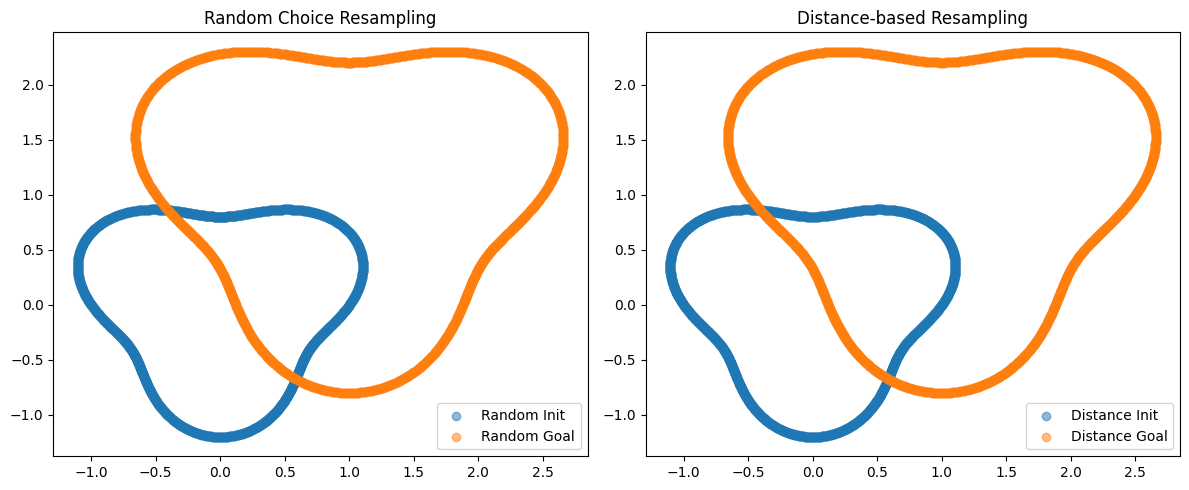

In [21]:
import numpy as np
from scipy.interpolate import interp1d
import time
from typing import Tuple

def random_resample_boundary_points(init_bd_pts: np.ndarray, 
                                  goal_bd_pts: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simple random resampling using np.random.choice
    """
    n1, n2 = len(init_bd_pts), len(goal_bd_pts)
    target_size = min(n1, n2)
    
    if n1 > target_size:
        indices = np.random.choice(n1, size=target_size, replace=False)
        init_bd_pts = init_bd_pts[indices]
    
    if n2 > target_size:
        indices = np.random.choice(n2, size=target_size, replace=False)
        goal_bd_pts = goal_bd_pts[indices]
        
    return init_bd_pts, goal_bd_pts

def distance_resample_boundary_points(init_bd_pts: np.ndarray, 
                                    goal_bd_pts: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Distance-based resampling using interpolation
    """
    target_size = min(len(init_bd_pts), len(goal_bd_pts))
    
    def resample_points(points: np.ndarray) -> np.ndarray:
        diffs = np.diff(points, axis=0)
        segment_lengths = np.sqrt(np.sum(diffs**2, axis=1))
        cumulative_dist = np.concatenate(([0], np.cumsum(segment_lengths)))
        cumulative_dist /= cumulative_dist[-1]
        
        fx = interp1d(cumulative_dist, points[:, 0], kind='linear')
        fy = interp1d(cumulative_dist, points[:, 1], kind='linear')
        
        new_t = np.linspace(0, 1, target_size)
        return np.column_stack([fx(new_t), fy(new_t)])
    
    return resample_points(init_bd_pts), resample_points(goal_bd_pts)

def generate_test_boundary(n_points: int, scale: float = 1.0, offset: float = 0.0) -> np.ndarray:
    """Generate test boundary points"""
    theta = np.linspace(0, 2*np.pi, n_points)
    r = 1 + 0.2 * np.sin(3*theta)
    x = r * np.cos(theta) * scale + offset
    y = r * np.sin(theta) * scale + offset
    return np.column_stack([x, y])

def compute_spacing_metrics(points: np.ndarray) -> dict:
    """Compute metrics for point spacing quality"""
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    return {
        'std_dev': np.std(distances),
        'range': np.max(distances) - np.min(distances),
        'mean_dist': np.mean(distances)
    }

# Test scenarios
sizes = [
    # (100, 150),    # Small difference
    # (1000, 800),   # Medium difference
    # (5000, 4000),  # Large difference
    # (10000, 8000)  # Very large difference
    (2000, 2100)
]

n_runs = 100  # Number of runs for each scenario for reliable timing

results = []
for n1, n2 in sizes:
    # Generate test data
    init_bd = generate_test_boundary(n1)
    goal_bd = generate_test_boundary(n2, scale=1.5, offset=1.0)
    
    # Time random choice method
    random_times = []
    random_metrics_init = []
    random_metrics_goal = []
    
    for _ in range(n_runs):
        start_time = time.perf_counter()
        random_init, random_goal = random_resample_boundary_points(init_bd, goal_bd)
        random_times.append(time.perf_counter() - start_time)
        
        if _ == 0:  # Only compute metrics once
            random_metrics_init.append(compute_spacing_metrics(random_init))
            random_metrics_goal.append(compute_spacing_metrics(random_goal))
    
    # Time distance-based method
    distance_times = []
    distance_metrics_init = []
    distance_metrics_goal = []
    
    for _ in range(n_runs):
        start_time = time.perf_counter()
        distance_init, distance_goal = distance_resample_boundary_points(init_bd, goal_bd)
        distance_times.append(time.perf_counter() - start_time)
        
        if _ == 0:  # Only compute metrics once
            distance_metrics_init.append(compute_spacing_metrics(distance_init))
            distance_metrics_goal.append(compute_spacing_metrics(distance_goal))
    
    # Store results
    results.append({
        'sizes': (n1, n2),
        'random_time_ms': np.mean(random_times) * 1000,
        'distance_time_ms': np.mean(distance_times) * 1000,
        'random_std_init': random_metrics_init[0]['std_dev'],
        'random_std_goal': random_metrics_goal[0]['std_dev'],
        'distance_std_init': distance_metrics_init[0]['std_dev'],
        'distance_std_goal': distance_metrics_goal[0]['std_dev']
    })

# Print results
print("\nPerformance Comparison:")
print("Size 1 | Size 2 | Random (ms) | Distance (ms) | Speedup")
print("-" * 60)
for result in results:
    n1, n2 = result['sizes']
    speedup = result['distance_time_ms'] / result['random_time_ms']
    print(f"{n1:6d} | {n2:6d} | {result['random_time_ms']:10.3f} | {result['distance_time_ms']:11.3f} | {speedup:7.2f}x")

print("\nQuality Metrics (Standard Deviation of Point Spacing):")
print("Size 1 | Size 2 | Random Init | Random Goal | Distance Init | Distance Goal")
print("-" * 75)
for result in results:
    n1, n2 = result['sizes']
    print(f"{n1:6d} | {n2:6d} | {result['random_std_init']:10.6f} | {result['random_std_goal']:10.6f} | "
          f"{result['distance_std_init']:12.6f} | {result['distance_std_goal']:12.6f}")

# Visual comparison for a small example
if True:
    import matplotlib.pyplot as plt
    
    # Generate small test case
    n1, n2 = 2000, 2100
    init_bd = generate_test_boundary(n1)
    goal_bd = generate_test_boundary(n2, scale=1.5, offset=1.0)
    
    # Get resampled points
    random_init, random_goal = random_resample_boundary_points(init_bd, goal_bd)
    distance_init, distance_goal = distance_resample_boundary_points(init_bd, goal_bd)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Random choice
    axes[0].scatter(random_init[:, 0], random_init[:, 1], label='Random Init', alpha=0.5)
    axes[0].scatter(random_goal[:, 0], random_goal[:, 1], label='Random Goal', alpha=0.5)
    axes[0].set_title('Random Choice Resampling')
    axes[0].legend()
    
    # Distance-based
    axes[1].scatter(distance_init[:, 0], distance_init[:, 1], label='Distance Init', alpha=0.5)
    axes[1].scatter(distance_goal[:, 0], distance_goal[:, 1], label='Distance Goal', alpha=0.5)
    axes[1].set_title('Distance-based Resampling')
    axes[1].legend()
    
    plt.tight_layout()


Testing sample size: 3

Testing sample size: 5

Testing sample size: 7

Testing sample size: 10

Testing sample size: 50

Testing sample size: 100

Testing sample size: 200

Testing sample size: 500

Testing sample size: 1000

Detailed Results:

Sample Size | Method   | Mean Error | Max Error | Std Error
------------------------------------------------------------
          3 | random   |     0.4126 |    0.9067 |    0.2273
          3 | distance |     0.3710 |    0.8345 |    0.1982
          5 | random   |     0.3691 |    0.9395 |    0.2275
          5 | distance |     0.3529 |    0.7380 |    0.1735
          7 | random   |     0.3980 |    0.8663 |    0.2229
          7 | distance |     0.3549 |    0.7353 |    0.1614
         10 | random   |     0.3550 |    0.8280 |    0.2197
         10 | distance |     0.3489 |    0.6970 |    0.1493
         50 | random   |     0.3379 |    0.8104 |    0.2084
         50 | distance |     0.3440 |    0.6604 |    0.1416
        100 | random   |     0.3

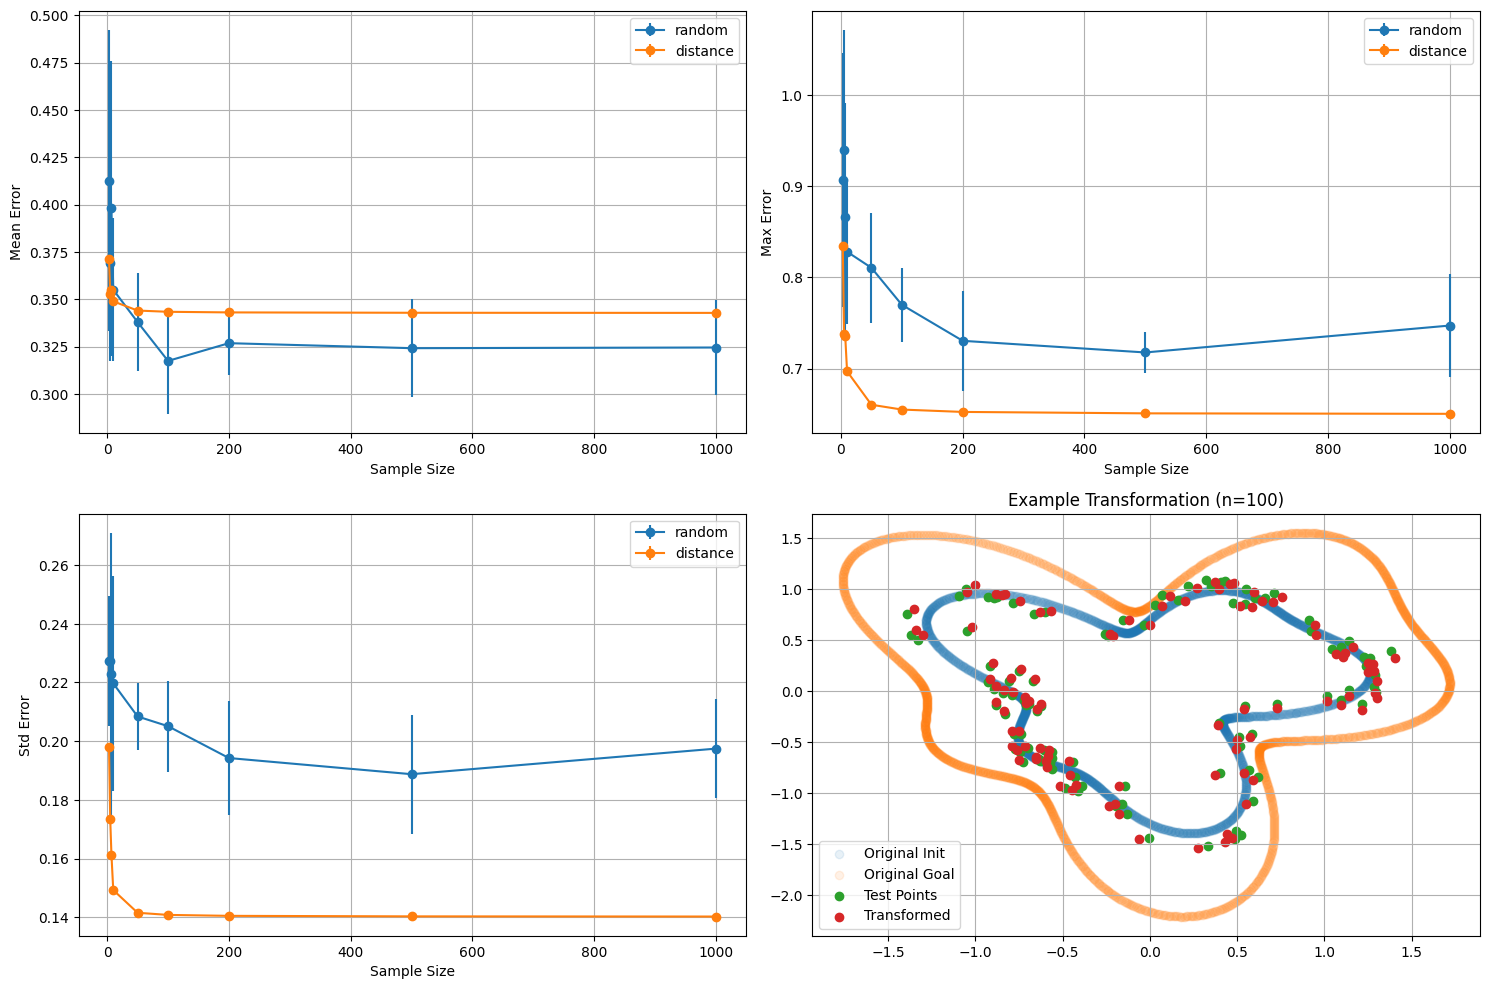

In [25]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import interp1d
import time
import matplotlib.pyplot as plt
from typing import Tuple, Dict

def generate_complex_boundary(n_points: int, scale: float = 1.0, phase: float = 0.0) -> np.ndarray:
    """Generate a complex boundary shape with multiple frequencies"""
    theta = np.linspace(0, 2*np.pi, n_points)
    r = 1 + 0.3*np.sin(3*theta) + 0.2*np.cos(5*theta + phase)
    x = r * np.cos(theta) * scale
    y = r * np.sin(theta) * scale
    return np.column_stack([x, y])

def random_resample_boundary_points(points: np.ndarray, target_size: int) -> np.ndarray:
    """Fast random resampling"""
    indices = np.random.choice(len(points), size=target_size, replace=False)
    return points[indices]

def distance_resample_boundary_points(points: np.ndarray, target_size: int) -> np.ndarray:
    """Even spacing resampling"""
    diffs = np.diff(points, axis=0)
    segment_lengths = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate(([0], np.cumsum(segment_lengths)))
    cumulative_dist /= cumulative_dist[-1]
    
    fx = interp1d(cumulative_dist, points[:, 0], kind='linear')
    fy = interp1d(cumulative_dist, points[:, 1], kind='linear')
    
    new_t = np.linspace(0, 1, target_size)
    return np.column_stack([fx(new_t), fy(new_t)])

def find_rigid_transform(A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Find optimal rigid transformation between point sets"""
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    Am = A - centroid_A
    Bm = B - centroid_B
    
    H = Am.T @ Bm
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    
    t = centroid_B - R @ centroid_A
    return R, t

def transform_points(points: np.ndarray, R: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Apply rigid transformation to points"""
    return (R @ points.T).T + t

def evaluate_transformation(original_pts: np.ndarray, 
                          transformed_pts: np.ndarray, 
                          target_pts: np.ndarray) -> Dict[str, float]:
    """Compute transformation quality metrics"""
    # Build KDTree for target boundary
    target_tree = KDTree(target_pts)
    
    # Find nearest neighbors and distances
    distances, _ = target_tree.query(transformed_pts)
    
    return {
        'mean_error': np.mean(distances),
        'max_error': np.max(distances),
        'std_error': np.std(distances),
        'median_error': np.median(distances)
    }

# Test parameters
original_size = 2000
sample_sizes = [3, 5, 7, 10, 50, 100, 200, 500, 1000]
n_test_points = 100  # Number of test points to transform
n_runs = 5  # Number of runs for each configuration

# Generate original boundaries
init_bd_pts = generate_complex_boundary(original_size)
goal_bd_pts = generate_complex_boundary(original_size, scale=1.5, phase=np.pi/4)

# Generate test points near initial boundary
test_points = init_bd_pts[np.random.choice(len(init_bd_pts), n_test_points)] + np.random.normal(0, 0.1, (n_test_points, 2))

# Results storage
results = {
    'random': {size: [] for size in sample_sizes},
    'distance': {size: [] for size in sample_sizes}
}

# Run experiments
for sample_size in sample_sizes:
    print(f"\nTesting sample size: {sample_size}")
    
    for run in range(n_runs):
        for method in ['random', 'distance']:
            # Resample boundaries
            if method == 'random':
                sampled_init = random_resample_boundary_points(init_bd_pts, sample_size)
                sampled_goal = random_resample_boundary_points(goal_bd_pts, sample_size)
            else:
                sampled_init = distance_resample_boundary_points(init_bd_pts, sample_size)
                sampled_goal = distance_resample_boundary_points(goal_bd_pts, sample_size)
            
            # Find transformation
            R, t = find_rigid_transform(sampled_init, sampled_goal)
            
            # Transform test points
            transformed_points = transform_points(test_points, R, t)
            
            # Evaluate transformation
            metrics = evaluate_transformation(test_points, transformed_points, goal_bd_pts)
            results[method][sample_size].append(metrics)

# Process and plot results
plt.figure(figsize=(15, 10))

# Plot metrics
metrics_to_plot = ['mean_error', 'max_error', 'std_error']
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    
    for method in ['random', 'distance']:
        means = [np.mean([run[metric] for run in results[method][size]]) for size in sample_sizes]
        stds = [np.std([run[metric] for run in results[method][size]]) for size in sample_sizes]
        
        plt.errorbar(sample_sizes, means, yerr=stds, label=method, marker='o')
    
    plt.xlabel('Sample Size')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)

# Print detailed results
print("\nDetailed Results:")
print("\nSample Size | Method   | Mean Error | Max Error | Std Error")
print("-" * 60)

for size in sample_sizes:
    for method in ['random', 'distance']:
        mean_metrics = {
            metric: np.mean([run[metric] for run in results[method][size]])
            for metric in ['mean_error', 'max_error', 'std_error']
        }
        
        print(f"{size:11d} | {method:8s} | {mean_metrics['mean_error']:10.4f} | "
              f"{mean_metrics['max_error']:9.4f} | {mean_metrics['std_error']:9.4f}")

# Visualize example transformation
plt.subplot(2, 2, 4)
sample_size = 100  # Choose a sample size for visualization
sampled_init = distance_resample_boundary_points(init_bd_pts, sample_size)
sampled_goal = distance_resample_boundary_points(goal_bd_pts, sample_size)
R, t = find_rigid_transform(sampled_init, sampled_goal)
transformed_points = transform_points(test_points, R, t)

plt.scatter(init_bd_pts[:, 0], init_bd_pts[:, 1], alpha=0.1, label='Original Init')
plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], alpha=0.1, label='Original Goal')
plt.scatter(test_points[:, 0], test_points[:, 1], label='Test Points')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], label='Transformed')
plt.legend()
plt.title(f'Example Transformation (n={sample_size})')
plt.grid(True)

plt.tight_layout()

Random Choice: 0.0001 seconds
Angle-Based Ordering: 0.0006 seconds
Nearest Neighbor Ordering (KD-tree): 0.7541 seconds
K-means Clustering: 0.0352 seconds


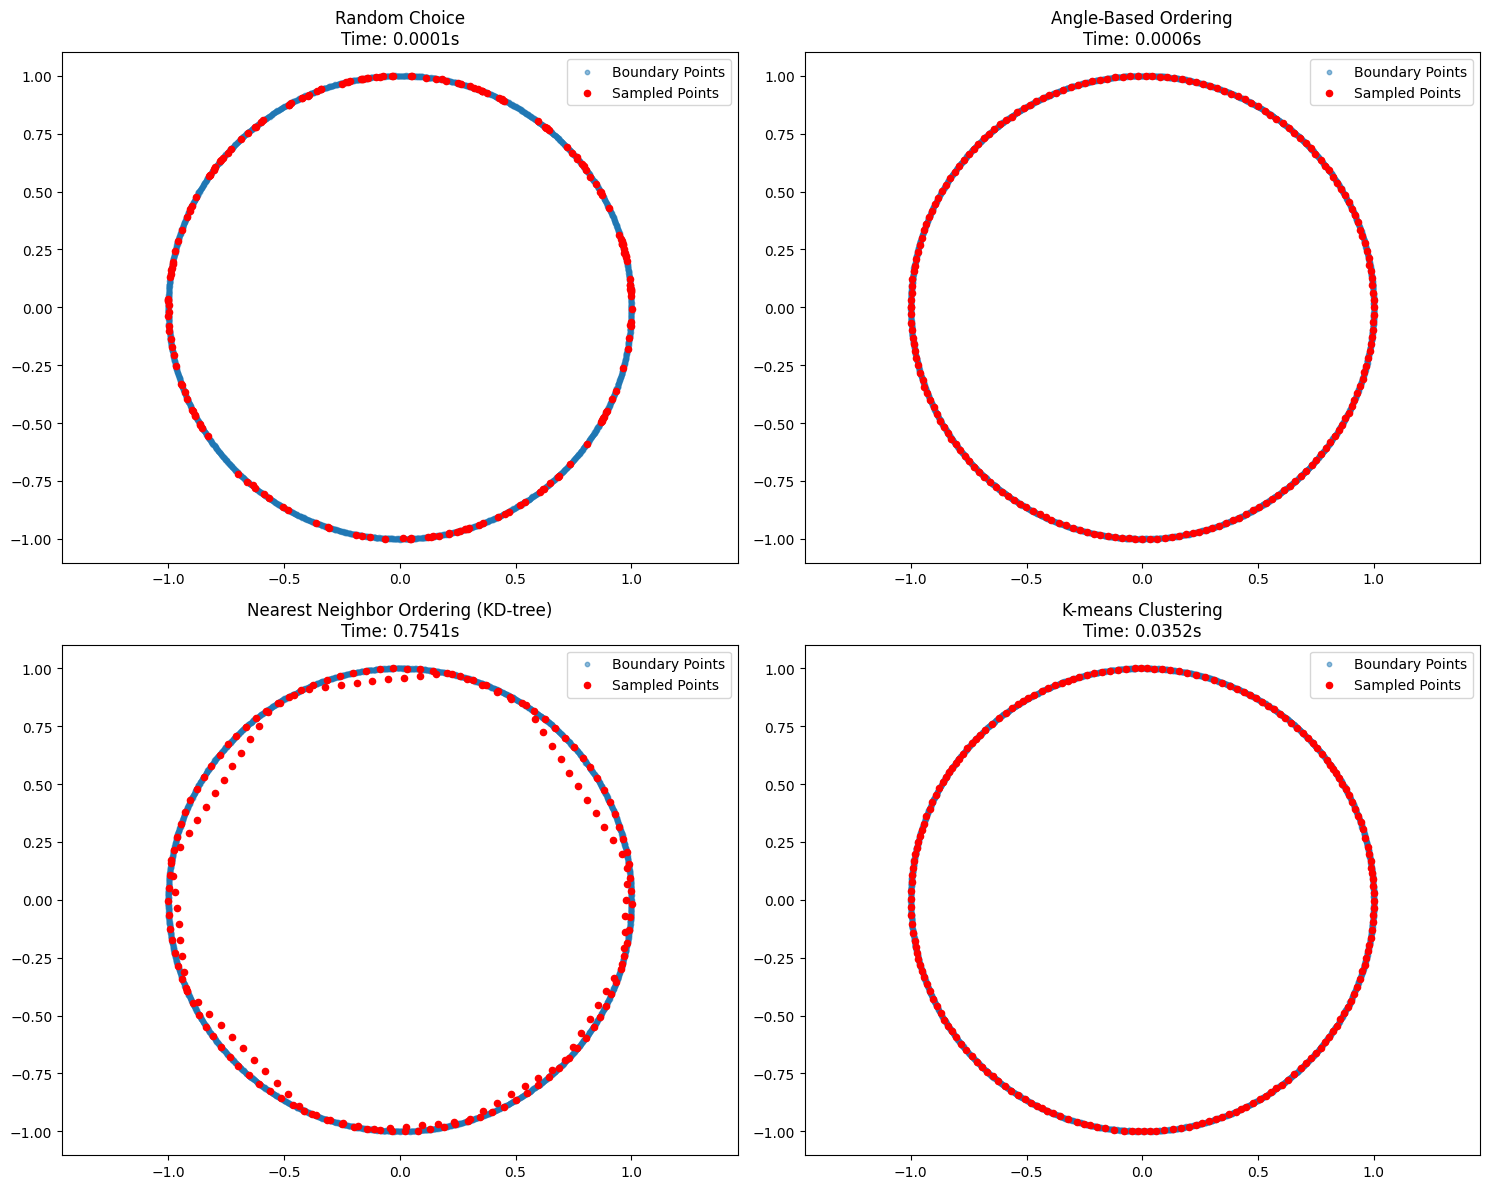

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
import time

# Generate example boundary points (unordered)
def generate_boundary_points(num_points=1000, noise=0.1):
    # Create a circle with noise
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = np.cos(angles) + noise * np.random.randn(num_points)
    y = np.sin(angles) + noise * np.random.randn(num_points)
    boundary_points = np.column_stack((x, y))
    np.random.shuffle(boundary_points)  # Shuffle to simulate unordered points
    return boundary_points

# Method 1: Random Choice
def sample_random_choice(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    indices = np.random.choice(len(boundary_points), size=n_samples, replace=False)
    return boundary_points[indices]

# Method 2: Angle-Based Ordering
def sample_angle_based(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    centroid = np.mean(boundary_points, axis=0)
    angles = np.arctan2(boundary_points[:,1] - centroid[1], boundary_points[:,0] - centroid[0])
    sorted_indices = np.argsort(angles)
    ordered_points = boundary_points[sorted_indices]
    ordered_points = np.vstack([ordered_points, ordered_points[0]])
    diffs = np.diff(ordered_points, axis=0)
    segment_lengths = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate(([0], np.cumsum(segment_lengths)))
    cumulative_dist /= cumulative_dist[-1]
    fx = interp1d(cumulative_dist, ordered_points[:, 0], kind='linear')
    fy = interp1d(cumulative_dist, ordered_points[:, 1], kind='linear')
    t = np.linspace(0, 1, n_samples)
    return np.column_stack([fx(t), fy(t)])

# Method 3: Nearest Neighbor Ordering (using KD-tree for efficiency)
from scipy.spatial import cKDTree

def sample_nearest_neighbor_kdtree(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    n_points = len(boundary_points)
    tree = cKDTree(boundary_points)
    ordered_points = [boundary_points[0]]
    visited = set([0])
    current_point = boundary_points[0]
    
    for _ in range(1, n_points):
        distances, indices = tree.query(current_point, k=n_points)
        for idx in indices:
            if idx not in visited:
                next_point = boundary_points[idx]
                ordered_points.append(next_point)
                visited.add(idx)
                current_point = next_point
                break
    ordered_points = np.array(ordered_points)
    ordered_points = np.vstack([ordered_points, ordered_points[0]])
    diffs = np.diff(ordered_points, axis=0)
    segment_lengths = np.sqrt(np.sum(diffs**2, axis=1))
    cumulative_dist = np.concatenate(([0], np.cumsum(segment_lengths)))
    cumulative_dist /= cumulative_dist[-1]
    fx = interp1d(cumulative_dist, ordered_points[:, 0], kind='linear')
    fy = interp1d(cumulative_dist, ordered_points[:, 1], kind='linear')
    t = np.linspace(0, 1, n_samples)
    return np.column_stack([fx(t), fy(t)])

# Method 4: K-means Clustering
def sample_kmeans_clustering(boundary_points: np.ndarray, n_samples: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    kmeans.fit(boundary_points)
    centroids = kmeans.cluster_centers_
    return centroids

# Main comparison function
def compare_methods():
    boundary_points = generate_boundary_points(num_points=3000, noise=0.001)
    n_samples = 200

    methods = {
        'Random Choice': sample_random_choice,
        'Angle-Based Ordering': sample_angle_based,
        'Nearest Neighbor Ordering (KD-tree)': sample_nearest_neighbor_kdtree,
        'K-means Clustering': sample_kmeans_clustering
    }

    results = {}
    times = {}

    for name, method in methods.items():
        start_time = time.time()
        sampled_points = method(boundary_points, n_samples)
        end_time = time.time()
        times[name] = end_time - start_time
        results[name] = sampled_points
        print(f"{name}: {times[name]:.4f} seconds")

    # Plotting for visual comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for ax, (name, sampled_points) in zip(axes, results.items()):
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], s=10, label='Boundary Points', alpha=0.5)
        if name == 'Random Choice' or name == 'K-means Clustering':
            ax.scatter(sampled_points[:, 0], sampled_points[:, 1], c='r', s=20, label='Sampled Points')
        else:
            ax.scatter(sampled_points[:, 0], sampled_points[:, 1], c='r', s=20, label='Sampled Points')
        ax.set_title(f"{name}\nTime: {times[name]:.4f}s")
        ax.legend()
        ax.axis('equal')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_methods()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Circle

class StateActionVisualizer:
    def visualize_state_and_actions(self, 
                                  robot_positions,      # Current active robot XY positions
                                  init_state,           # Initial state with relative positions
                                  actions,              # Actions for each robot
                                  block_position,       # Current block position
                                  n_idxs,              # Number of active robots
                                  all_robot_positions,  # All possible robot positions (kdtree_positions_world)
                                  active_idxs,         # Indices of active robots
                                  figsize=(12, 6)):
        """
        Visualize the current state and actions of the robotic manipulation system
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: State Visualization
        self._plot_state(ax1, robot_positions, init_state, block_position, n_idxs, 
                        all_robot_positions, active_idxs)
        
        # Plot 2: Action Visualization
        self._plot_actions(ax2, robot_positions, actions, block_position, n_idxs,
                          all_robot_positions, active_idxs)
        
        plt.tight_layout()
        return fig

    def _plot_state(self, ax, robot_positions, init_state, block_position, n_idxs, 
                    all_robot_positions, active_idxs):
        """Plot the current state, including robots, block, and boundary points"""
        # Plot all possible robot positions with transparency
        ax.scatter(all_robot_positions[:,0], all_robot_positions[:,1], 
                  color='gray', alpha=0.4, s=30, label='Available Positions')
        
        # Plot block
        ax.add_patch(Circle(block_position[:2], radius=0.05, color='gray', alpha=0.3))
        
        # Plot active robots
        for i in range(n_idxs):
            # Plot active robot position
            ax.add_patch(Circle(robot_positions[i], radius=0.02, color='red'))
            
            # Plot initial boundary points (relative to block)
            init_point = init_state[i, :2] + block_position[:2]
            goal_point = init_state[i, 2:4] + block_position[:2]
            
            # Plot init points
            ax.scatter(init_point[0], init_point[1], color='blue', marker='x', s=100, 
                      label='Init BP' if i==0 else '')
            # Plot goal points
            ax.scatter(goal_point[0], goal_point[1], color='green', marker='o', s=100, 
                      label='Goal BP' if i==0 else '')
            
            # Draw lines connecting active robots to their assigned boundary points
            ax.plot([robot_positions[i,0], init_point[0]], 
                   [robot_positions[i,1], init_point[1]], 
                   'k--', alpha=0.3)
        
        # Highlight active robot positions
        ax.scatter(robot_positions[:,0], robot_positions[:,1], 
                  color='red', s=50, label='Active Robots')

        ax.set_title('State Visualization')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')

    def _plot_actions(self, ax, robot_positions, actions, block_position, n_idxs,
                      all_robot_positions, active_idxs):
        """Plot the current actions as vectors from robot positions"""
        # Plot all possible robot positions with transparency
        ax.scatter(all_robot_positions[:,0], all_robot_positions[:,1], 
                  color='gray', alpha=0.4, s=30)
        
        # Plot block
        ax.add_patch(Circle(block_position[:2], radius=0.05, color='gray', alpha=0.3))
        
        # Plot active robots and their actions
        for i in range(n_idxs):
            # Plot robot
            ax.add_patch(Circle(robot_positions[i], radius=0.02, color='red'))
            
            # Plot action vector
            action = actions[i].reshape(-1)
            ax.add_patch(Arrow(robot_positions[i,0], 
                             robot_positions[i,1],
                             action[0] * 0.5,  # Scale factor for visualization
                             action[1] * 0.5,
                             width=0.02,
                             color='purple'))

        # Highlight active robot positions
        ax.scatter(robot_positions[:,0], robot_positions[:,1], 
                  color='red', s=50)

        ax.set_title('Action Visualization')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True)
        ax.axis('equal')

    def animate_execution(self, 
                        robot_positions_history, 
                        block_position_history,
                        actions_history,
                        init_state,
                        n_idxs,
                        all_robot_positions,
                        active_idxs,
                        interval=100):
        """
        Create an animation of the execution
        """
        from matplotlib.animation import FuncAnimation
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        def update(frame):
            ax.clear()
            robot_pos = robot_positions_history[frame]
            block_pos = block_position_history[frame]
            actions = actions_history[frame]
            
            # Plot all possible positions
            ax.scatter(all_robot_positions[:,0], all_robot_positions[:,1], 
                      color='gray', alpha=0.4, s=30)
            
            # Plot current state
            self._plot_state(ax, robot_pos, init_state, block_pos, n_idxs,
                           all_robot_positions, active_idxs)
            
            # Plot current actions
            for i in range(n_idxs):
                action = actions[i].reshape(-1)
                ax.add_patch(Arrow(robot_pos[i,0], 
                                 robot_pos[i,1],
                                 action[0] * 0.5,
                                 action[1] * 0.5,
                                 width=0.02,
                                 color='purple'))
            
            ax.set_title(f'Frame {frame}')
            
        anim = FuncAnimation(fig, update, 
                           frames=len(robot_positions_history),
                           interval=interval)
        return anim

# Example usage
def example_visualization():
    visualizer = StateActionVisualizer()
    
    # Example data
    n_idxs = 4
    all_positions = np.random.rand(20, 2) * 0.5  # All possible positions
    active_idxs = np.array([0, 5, 10, 15])  # Example active indices
    robot_positions = all_positions[active_idxs]
    block_position = np.array([0.5, 0.5, 0])
    init_state = np.random.rand(n_idxs, 4) * 0.2 - 0.1
    actions = np.random.rand(n_idxs, 2) * 0.06 - 0.03
    
    # Create visualization
    fig = visualizer.visualize_state_and_actions(
        robot_positions=robot_positions,
        init_state=init_state,
        actions=actions,
        block_position=block_position,
        n_idxs=n_idxs,
        all_robot_positions=all_positions,
        active_idxs=active_idxs
    )
    
    return fig

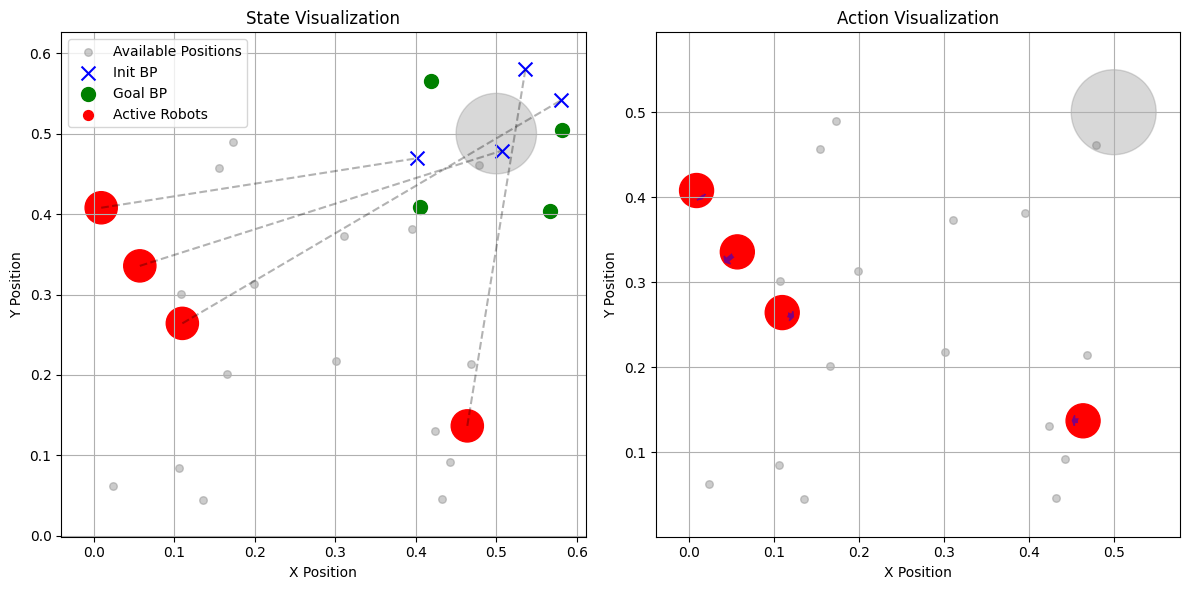

In [12]:
visualizer = StateActionVisualizer()

# During execution
fig = example_visualization()

plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import heapq
from skimage.morphology import skeletonize
import open3d as o3d
import time

img_size = np.array((1080, 1920))
plane_size = np.array([(-0.06, -0.2035), (0.3225, 0.485107)])

l_b=np.array([35,50,50])# lower hsv bound for green
u_b=np.array([85,255,255])# upper hsv bound to green
kernel = np.ones((31,31),np.uint8)

""" Robot positions and neighborhood parameters """
robot_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            robot_positions[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            robot_positions[i,j] = np.array((i*0.0375, j*0.043301))

def icp(a, b, icp_radius = 200):
    a = np.hstack([a, np.zeros([a.shape[0],1])])
    b = np.hstack([b, np.zeros([b.shape[0],1])])
    src = o3d.geometry.PointCloud()
    dest = o3d.geometry.PointCloud()
    src.points = o3d.utility.Vector3dVector(a)
    dest.points = o3d.utility.Vector3dVector(b)
    reg_p2p = o3d.pipelines.registration.registration_icp(src, dest, icp_radius, np.identity(4),
                            o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return reg_p2p.transformation   

class RopeSearch:
    def __init__(self, rope_coms, skeleton):
        self.rope_coms = rope_coms
        self.inv_rope_coms = {com.tobytes(): n for n, com in enumerate(self.rope_coms)}
        self.skeleton = skeleton
        self.map = {}
        self.make_map()
        self.graph = {}
    
    def make_map(self):
        self.end_points = []
        for idx in range(len(self.rope_coms)):
            neighbors = self.get_neighbors(idx)
            self.map[idx] = neighbors
            if (len(neighbors) == 1) or (len(neighbors) >= 3):
                self.end_points.append(idx)
                
    def get_neighbors(self, idx):
        xy = self.rope_coms[idx]
        crop = np.transpose(np.where(self.skeleton[xy[0]-1:xy[0]+2, xy[1]-1:xy[1]+2]==1)) - 1
        locs = xy + crop
        neighbors = locs[np.transpose(np.where(np.logical_or(locs[:,0]!=xy[0],locs[:,1]!=xy[1])))]
        neighbors = [self.inv_rope_coms[nbr.tobytes()] for nbr in neighbors]
        return neighbors
    
    def dijkstra(self):
        for idx in self.end_points:
            distances = {node: float('inf') for node in self.map}
            distances[idx] = 0
            visited = set()
            queue = [(0, idx)]
            while queue:
                dist, node = heapq.heappop(queue)
                if node in visited:
                    continue
                visited.add(node)
                for neighbor in self.map[node]:
                    if neighbor in visited:
                        continue
                    dist += 1
                    if dist < distances[neighbor]:
                        distances[neighbor] = dist
                        self.graph[neighbor] = node
                        heapq.heappush(queue, (dist, neighbor))
                        
            for idx2 in self.end_points:
                if distances[idx2] > self.rope_coms.shape[0]*0.9:
                    path = [idx2]
                    while idx2 != idx:
                        idx2 = self.graph[idx2]
                        path.append(idx2)
                    path.append(idx)
                    return path
                
def get_rope_coms(frame, resize=False):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    if resize:
        frame = cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2))
    mask = cv2.inRange(frame, l_b, u_b)
    
    skeleton = skeletonize(mask//255, method='lee')
    rope_coms = np.array(np.where(skeleton==1)).T

    rope_search = RopeSearch(rope_coms, skeleton)
    rope_path = rope_search.dijkstra()
    rope_points = rope_coms[rope_path]
    return rope_points

Time taken: 0.17792129516601562
(801, 2) (774, 2)


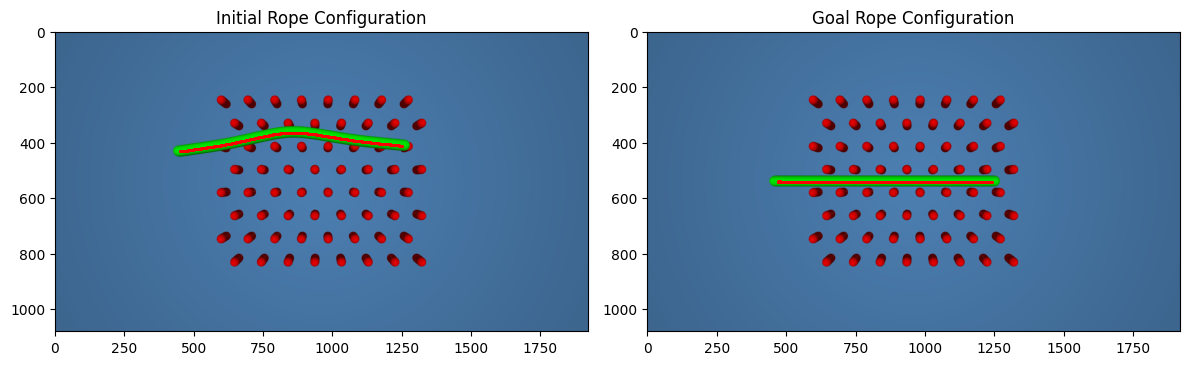

In [32]:
now = time.time()

init_frame = cv2.imread("./data/temp/rope_init.png")
init_rope_coms = np.flip(get_rope_coms(init_frame))

goal_frame = cv2.imread("./data/temp/rope_goal.png")
goal_rope_coms = np.flip(get_rope_coms(goal_frame))
print("Time taken:", time.time()-now)

print(init_rope_coms.shape, goal_rope_coms.shape)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(init_frame, cv2.COLOR_BGR2RGB))
plt.scatter(init_rope_coms[:, 0], init_rope_coms[:, 1], s=1, c='r')
plt.title("Initial Rope Configuration")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(goal_frame, cv2.COLOR_BGR2RGB))
plt.scatter(goal_rope_coms[:, 0], goal_rope_coms[:, 1], s=1, c='r')
plt.title("Goal Rope Configuration")

plt.tight_layout()
plt.show()

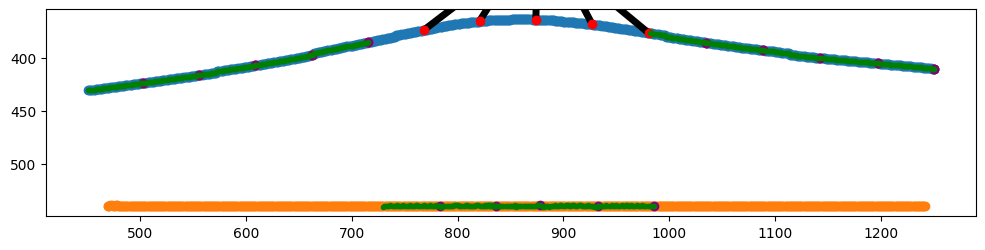

CPU times: user 1min 57s, sys: 300 ms, total: 1min 58s
Wall time: 1.17 s


In [ ]:
%%time
# rope_points2 = rope_points
# rope_points1 = rope_points

split_rope1 = np.array_split(init_rope_coms, 15)
split_rope2 = np.array_split(goal_rope_coms[::-1], 15)

# plt.scatter(*split_rope1[0].T)
# plt.scatter(*split_rope2[0].T)

fig = plt.figure(figsize=(12,6))
plt.gca().set_aspect('equal')
plt.scatter(*init_rope_coms.T)
plt.scatter(*goal_rope_coms.T)
for i in range(15):
    idx_thresh = min(split_rope1[i].shape[0], split_rope2[i].shape[0])
    M2 = icp(split_rope1[i][:idx_thresh],split_rope2[i][:idx_thresh], icp_radius = 300)
    TF_Matrix = np.zeros((2,3))
    TF_Matrix[:, :2] = M2[:2, :2]
    TF_Matrix[:, -1] = M2[:2, -1]
    
    split_rope3 = (TF_Matrix[:, :2]@split_rope1[i].T).T + TF_Matrix[:, -1]
    
    pt1 = split_rope1[i][0]
    pt2 = (TF_Matrix[:, :2]@pt1.T).T + TF_Matrix[:, -1]
    
    
    
    plt.quiver(*pt1, *(pt2-pt1), scale=600)
    
    plt.scatter(*pt1, color="red")
    plt.scatter(*pt2, color="purple")
    plt.plot(*split_rope3.T[:2], 'g.')
    
plt.gca().invert_yaxis()
plt.show()

(814, 2) (784, 2)


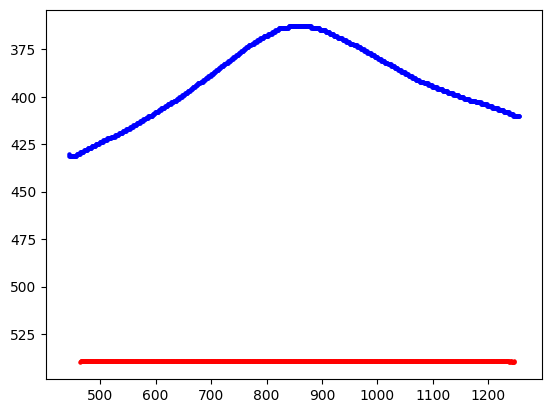

[array([0, 1]), array([0, 1, 2]), array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6]), array([5, 6, 7]), array([6, 7, 8]), array([7, 8, 9]), array([ 8,  9, 10]), array([ 9, 10, 11]), array([10, 11, 12]), array([11, 12, 13]), array([12, 13, 14]), array([13, 14, 15]), array([14, 15, 16]), array([15, 16, 17]), array([16, 17, 18]), array([17, 18, 19]), array([18, 19, 20]), array([19, 20, 21]), array([20, 21, 22]), array([21, 22, 23]), array([22, 23, 24]), array([23, 24, 25]), array([24, 25, 26]), array([25, 26, 27]), array([26, 27, 28]), array([27, 28, 29]), array([28, 29, 30]), array([29, 30, 31]), array([30, 31, 32]), array([31, 32, 33]), array([32, 33, 34]), array([33, 34, 35]), array([34, 35, 36]), array([35, 36, 37]), array([36, 37, 38]), array([37, 38, 39]), array([38, 39, 40]), array([39, 40]), array([41, 42]), array([41, 42, 43]), array([42, 43, 44]), array([43, 44, 45]), array([44, 45, 46]), array([45, 46, 47]), array([46, 47, 48]), array([47, 48, 49]), array([4

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
from scipy.interpolate import splprep, splev
from skimage.morphology import skeletonize
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
import time

def get_centerline(mask):
    skeleton = skeletonize(mask > 0)
    return np.array(np.where(skeleton==1)).T

def find_endpoints(points):
    dist_matrix = distance.cdist(points, points)
    neighbors = [np.where(dist_matrix[i] < 1.3)[0] for i in range(len(points))]
    print(neighbors)
    
    # Points with only one neighbor are endpoints
    endpoints = [i for i, n in enumerate(neighbors) if len(n) <= 2]
    # If no clear endpoints (closed loop), take points with largest distance
    if len(endpoints) < 2:
        i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
        endpoints = [i, j]
        
    return endpoints

def order_points(points, start_idx):
    """Order points starting from start_idx using nearest neighbors"""
    ordered = [start_idx]
    remaining = set(range(len(points))) - {start_idx}
    current = start_idx
    
    while remaining:
        # Find closest remaining point to current point
        distances = distance.cdist([points[current]], points[remaining])
        next_idx = list(remaining)[np.argmin(distances)]
        
        ordered.append(next_idx)
        remaining.remove(next_idx)
        current = next_idx
        
    return points[ordered]

def extract_rope_points(init_mask, goal_mask):
    init_points = get_centerline(init_mask)
    goal_points = get_centerline(goal_mask)
    print(init_points.shape, goal_points.shape)
    plt.scatter(init_points[:,1], init_points[:,0], c='b', s=5)
    plt.scatter(goal_points[:,1], goal_points[:,0], c='r', s=5)
    plt.gca().invert_yaxis()
    plt.show()
    
    
    init_endpoints = find_endpoints(init_points)
    init_ordered = order_points(init_points, init_endpoints[0])
    
    goal_endpoints = find_endpoints(goal_points)
    goal_ordered_1 = order_points(goal_points, goal_endpoints[0])
    goal_ordered_2 = np.flipud(goal_ordered_1)  # Reverse order
    
    cost_1 = np.sum(np.linalg.norm(goal_ordered_1 - init_ordered, axis=1))
    cost_2 = np.sum(np.linalg.norm(goal_ordered_2 - init_ordered, axis=1))
    
    goal_ordered = goal_ordered_1 if cost_1 < cost_2 else goal_ordered_2
    return init_ordered, goal_ordered

def compute_configuration_cost(init_points, goal_points):
    init_centered = init_points - np.mean(init_points, axis=0)
    goal_centered = goal_points - np.mean(goal_points, axis=0)
    
    cost_matrix = distance.cdist(init_centered, goal_centered)
    
    # Use Hungarian algorithm to find optimal point correspondence
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_cost = cost_matrix[row_ind, col_ind].sum()
    
    # Add shape difference penalty
    init_shape = np.diff(init_centered, axis=0)
    goal_shape = np.diff(goal_centered, axis=0)
    shape_diff = np.linalg.norm(init_shape - goal_shape)
    
    total_cost = assignment_cost + shape_diff
    return total_cost

now = time.time()
goal_frame = cv2.imread("./data/temp/rope_goal.png")
goal_frame = cv2.cvtColor(goal_frame, cv2.COLOR_BGR2HSV)
goal_mask = cv2.inRange(goal_frame, l_b, u_b)

init_frame = cv2.imread("./data/temp/rope_init.png")
init_frame = cv2.cvtColor(init_frame, cv2.COLOR_BGR2HSV)
init_mask = cv2.inRange(init_frame, l_b, u_b)

init_points, goal_points = extract_rope_points(init_mask, goal_mask)
cost = compute_configuration_cost(init_points, goal_points)
print(f"Configuration difference cost: {cost}")
print("Elapsed time:", time.time() - now)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(init_points[:,0], init_points[:,1], c=np.arange(len(init_points)), cmap='viridis')
plt.title('Initial Configuration')
plt.colorbar(label='Point Order')

plt.subplot(122)
plt.scatter(goal_points[:,0], goal_points[:,1], c=np.arange(len(goal_points)), cmap='viridis')
plt.title('Goal Configuration')
plt.colorbar(label='Point Order')
plt.show()

# plot goal_frame and overlay the init_mask with transparency of 0.7
plt.imshow(cv2.cvtColor(goal_frame, cv2.COLOR_HSV2RGB))
plt.imshow(goal_mask, cmap='gray', alpha=0.9)
plt.show()
plt.imshow(cv2.cvtColor(init_frame, cv2.COLOR_BGR2RGB))
plt.imshow(init_mask, cmap='gray', alpha=0.9)
plt.show()

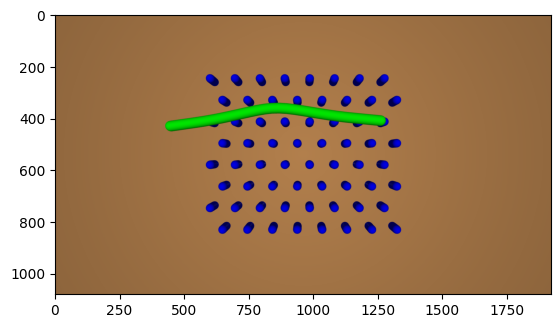

Time taken: 0.22454237937927246


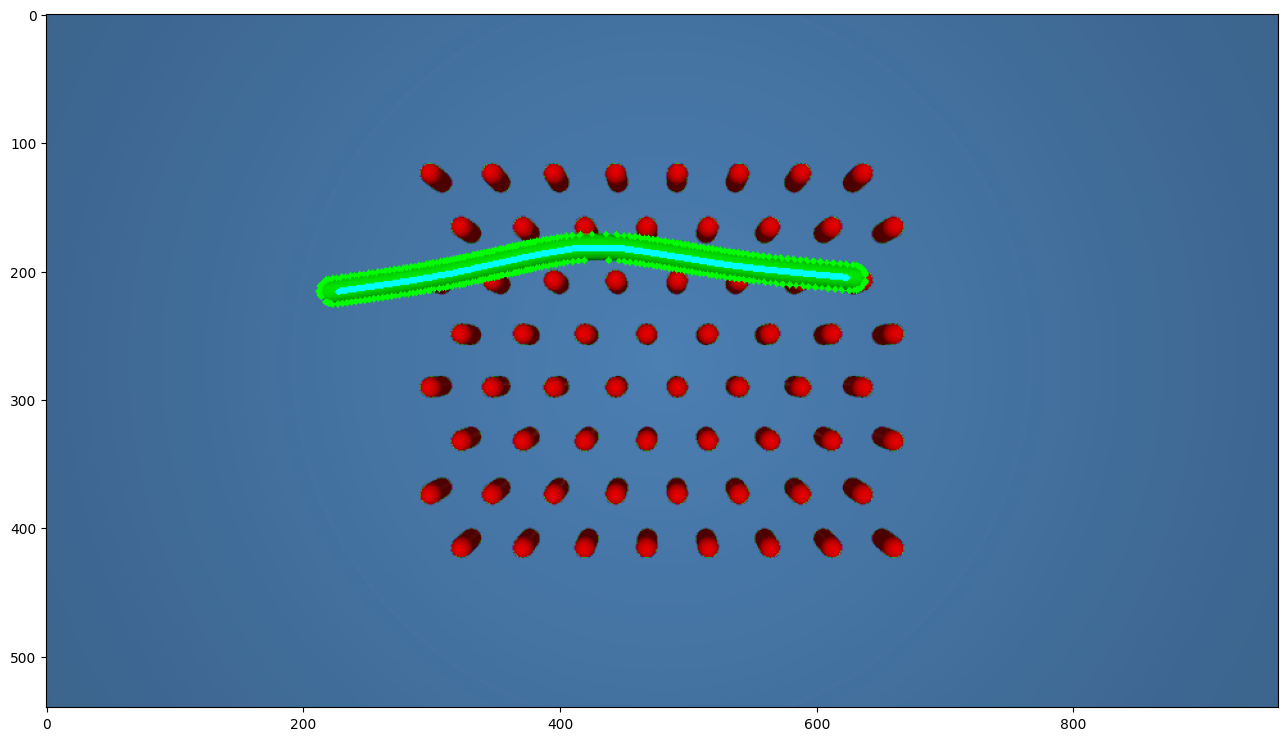

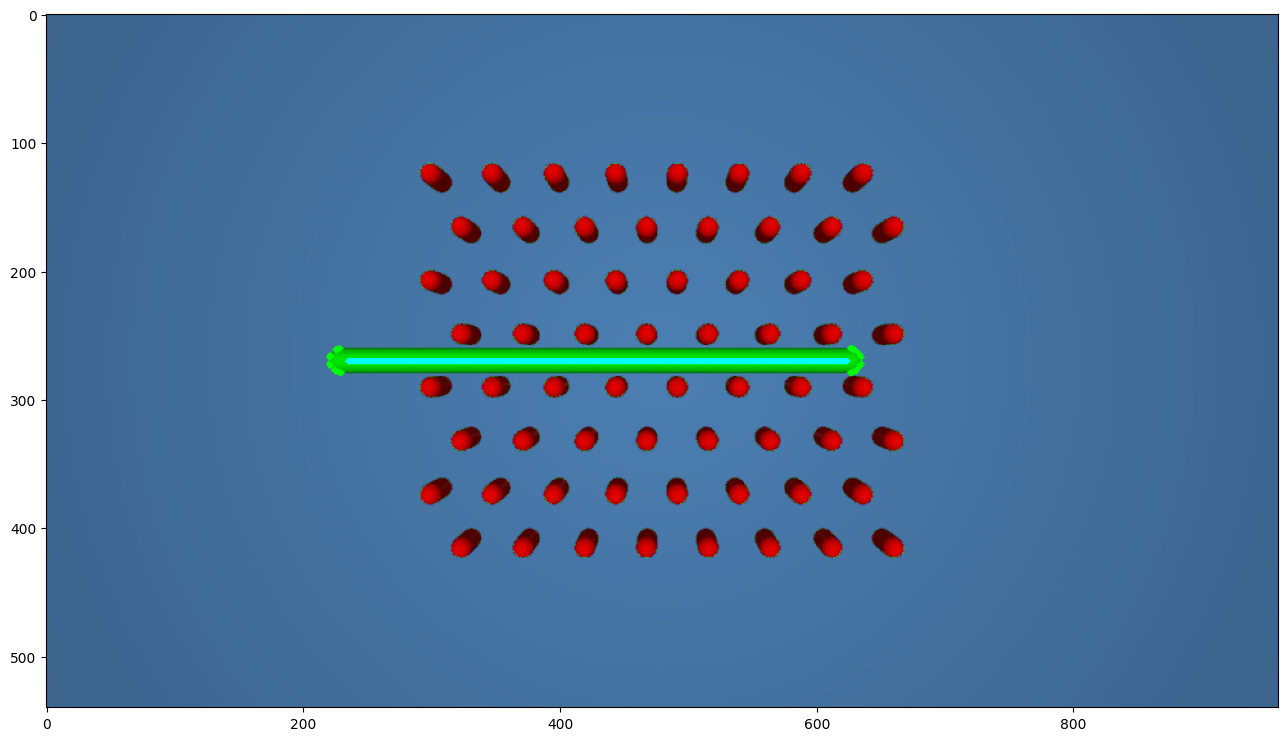

In [ ]:
now = time.time()

frame = cv2.imread("./data/temp/rope_init.png")
plt.imshow(frame)
plt.show()
rope2 = np.flip(get_rope_coms(frame))
rope2[:,0] = rope2[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]
rope2[:,1] = rope2[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]

frame = cv2.imread("./data/temp/rope_goal.png")
rope1 = np.flip(get_rope_coms(frame))
rope1[:,0] = rope1[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]
rope1[:,1] = rope1[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]

print("Time taken:", time.time()-now)

Total Cost: 6159.2688203614025
Elapsed time: 0.18198180198669434


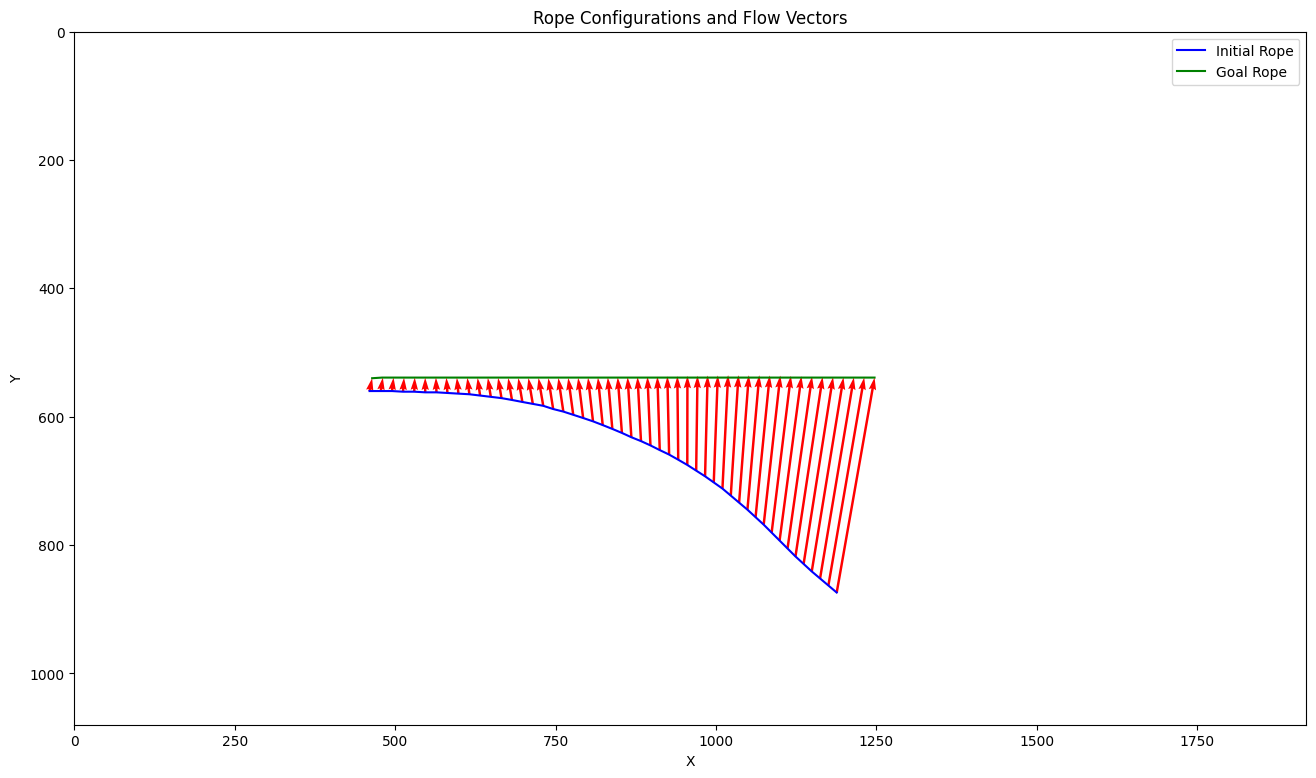

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.ndimage import convolve
from scipy.spatial import cKDTree

def read_and_threshold_image(image_path, lower_green, upper_green):
    """Reads an image and applies HSV thresholding to obtain a binary mask."""
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    return mask > 0  # Return boolean mask

def skeletonize_mask(mask):
    """Skeletonizes the binary mask to obtain the centerline."""
    return skeletonize(mask)

def order_skeleton_points(skeleton):
    """Orders the skeleton points along the centerline."""
    coords = np.column_stack(np.nonzero(skeleton))
    num_pixels = coords.shape[0]
    indices_map = {tuple(coord): idx for idx, coord in enumerate(coords)}
    adj_list = [[] for _ in range(num_pixels)]
    for idx, (y, x) in enumerate(coords):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (ny, nx) in indices_map:
                    nbr_idx = indices_map[(ny, nx)]
                    adj_list[idx].append(nbr_idx)
    degrees = [len(adj) for adj in adj_list]
    endpoints = [idx for idx, deg in enumerate(degrees) if deg == 1]
    if len(endpoints) < 2:
        print("Cannot find endpoints.")
        return coords
    start = endpoints[0]
    ordered_indices = []
    visited = np.zeros(num_pixels, dtype=bool)
    stack = [start]
    while stack:
        current = stack.pop()
        if visited[current]:
            continue
        visited[current] = True
        ordered_indices.append(current)
        for nbr in adj_list[current]:
            if not visited[nbr]:
                stack.append(nbr)
    ordered_coords = coords[ordered_indices]
    return ordered_coords

def sample_points(ordered_coords, total_points):
    """Samples equidistant points along the ordered skeleton coordinates."""
    diffs = np.diff(ordered_coords, axis=0)
    dists = np.hypot(diffs[:, 0], diffs[:, 1])
    cumulative_dist = np.hstack(([0], np.cumsum(dists)))
    total_length = cumulative_dist[-1]
    sample_dists = np.linspace(0, total_length, total_points)
    sampled_points = np.empty((total_points, 2))
    sampled_points[:, 0] = np.interp(sample_dists, cumulative_dist, ordered_coords[:, 0])
    sampled_points[:, 1] = np.interp(sample_dists, cumulative_dist, ordered_coords[:, 1])
    return sampled_points

def compute_flow_vectors(init_points, goal_points):
    """Computes flow vectors between corresponding points."""
    return goal_points - init_points

def get_rope_flows(init_coords, goal_coords, N=16, M=1):
    """ N: Number of chunks on the rope, M: Points per chunk """
    init_coords = sample_points(init_coords, N * M)
    goal_coords_0 = sample_points(goal_coords, N * M)
    goal_coords_1 = goal_coords_0[::-1]
    
    cost = np.sum(np.linalg.norm(goal_coords_0 - init_coords, axis=1))
    cost1 = np.sum(np.linalg.norm(goal_coords_1 - init_coords, axis=1))
    if cost1 < cost:
        return goal_coords_1 - init_coords
    else:
        return goal_coords_0 - init_coords
    
def calculate_cost(flow_vectors):
    """Calculates the cost as the sum of distances between corresponding points."""
    differences = np.linalg.norm(flow_vectors, axis=1)
    return np.sum(differences)

def plot_ropes_and_flows(init_points, goal_points, flow_vectors):
    """Plots the ropes and flow vectors."""
    init_x, init_y = init_points[:, 1], init_points[:, 0]
    goal_x, goal_y = goal_points[:, 1], goal_points[:, 0]
    plt.figure(figsize=(16, 9))
    plt.plot(init_x, init_y, 'b-', label='Initial Rope')
    plt.plot(goal_x, goal_y, 'g-', label='Goal Rope')
    plt.quiver(init_x, init_y, flow_vectors[:, 1], flow_vectors[:, 0],
               angles='xy', scale_units='xy', scale=1, color='r', width=0.002)
    plt.legend()
    plt.xlim(0, 1920)
    plt.ylim(0, 1080)  # Invert y-axis
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()
    plt.title('Rope Configurations and Flow Vectors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

now = time.time()
# Read and threshold images
init_mask = read_and_threshold_image("./data/temp/rope_init.png", lower_green, upper_green)
goal_mask = read_and_threshold_image("./data/temp/rope_goal.png", lower_green, upper_green)

# Skeletonize masks
init_skeleton = skeletonize_mask(init_mask)
goal_skeleton = skeletonize_mask(goal_mask)

# Order skeleton points
init_ordered_coords = order_skeleton_points(init_skeleton)
goal_ordered_coords = order_skeleton_points(goal_skeleton)

# Sample equidistant points along the skeletons
N = 50  # Number of chunks
M = 1  # Points per chunk
total_points = N * M


init_sampled_points = sample_points(init_ordered_coords, total_points)
goal_sampled_points = sample_points(goal_ordered_coords, total_points)

# Compute flow vectors and cost
flow_vectors = get_rope_flows(init_sampled_points, goal_sampled_points, N, M)
total_cost = calculate_cost(flow_vectors)
print(f"Total Cost: {total_cost}")
print("Elapsed time:", time.time() - now)

# Plot ropes and flow vectors
plot_ropes_and_flows(init_sampled_points, goal_sampled_points, flow_vectors)

Estimated number of stored entries: 36500
Observation buffer shape: (36500, 64, 6)
Action buffer shape: (36500, 64, 2)
Reward buffer shape: (36500,)
Number of agents buffer shape: (36500,)


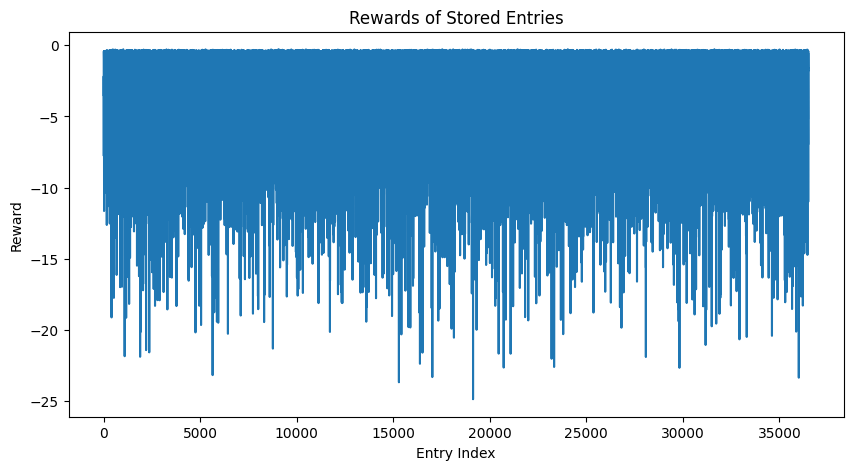

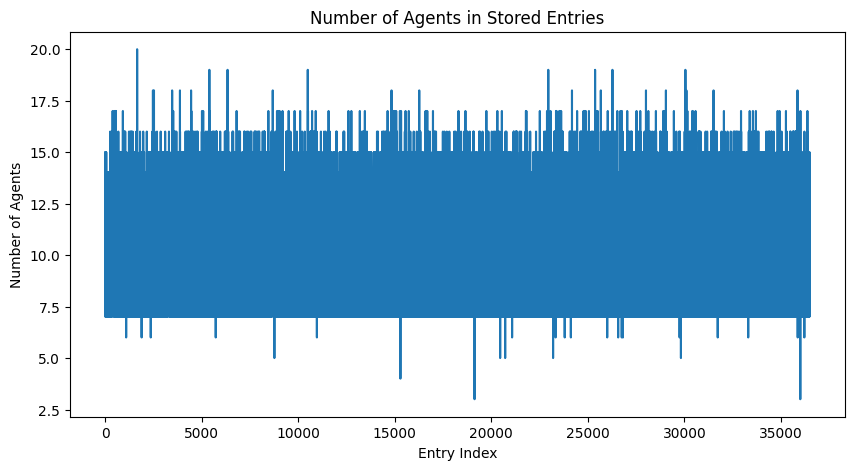

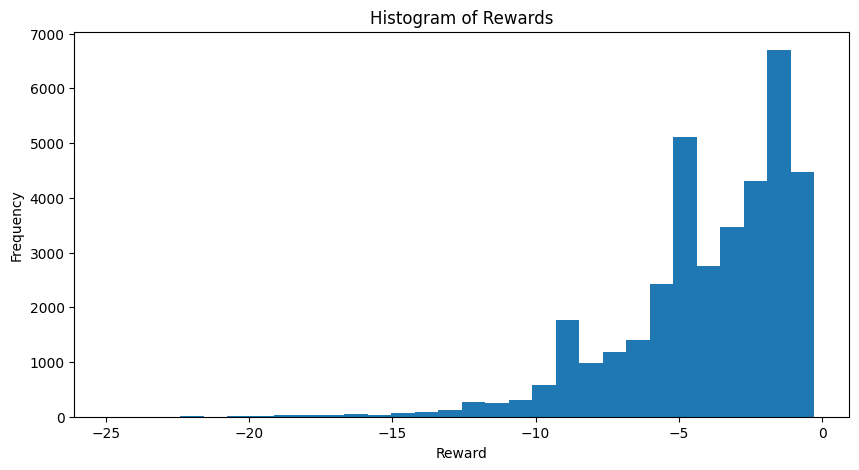

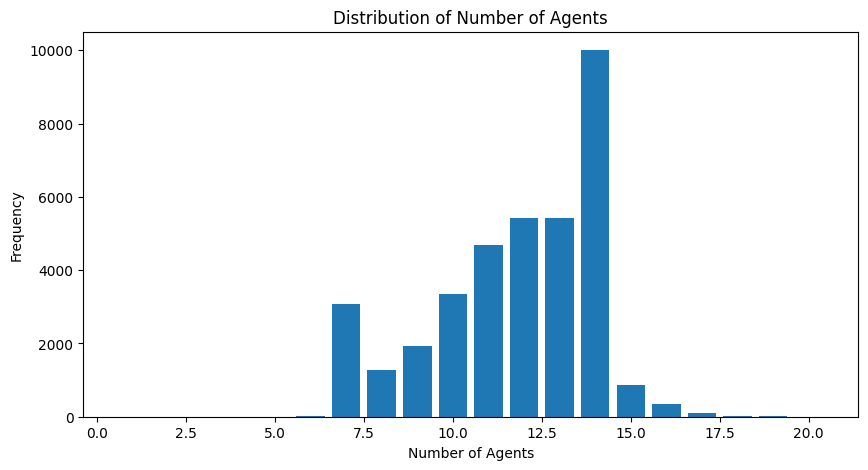

Minimum reward: -24.869123458862305
Maximum reward: -0.2757146656513214
Checked agent counts for all entries.

Random entry at index 28523:
Observations: [[-0.00320833  0.0162201   0.01839583  0.0162201  -0.01664514  0.02831359]
 [-0.00320833 -0.0270809   0.01839583 -0.0270809  -0.00815442 -0.0130787 ]
 [-0.0077152  -0.02851844  0.01839583 -0.03074213  0.001222   -0.01543445]
 [ 0.02933333 -0.00080797  0.05589584 -0.00334522  0.01951116 -0.01967301]
 [ 0.02512976 -0.01461063  0.05589584 -0.01791668  0.01244823  0.02341469]
 [-0.01408992 -0.02447799  0.01839583 -0.02807586 -0.00888303 -0.00869048]
 [ 0.01941667 -0.02278818  0.05589584 -0.02674222  0.0046887  -0.02717977]
 [-0.02304167 -0.01525069  0.01839583 -0.01966368 -0.02782302 -0.01932012]
 [ 0.01304167 -0.02499266  0.05589584 -0.02982186  0.01429752 -0.01968792]
 [-0.02410417 -0.01585579  0.01839583 -0.02274332 -0.02460618  0.00844824]
 [ 0.01492203 -0.02564272  0.05589584 -0.0329015   0.00692231 -0.02878295]
 [-0.01772917 -0.0180

In [11]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

# Load the saved replay buffer
with open("./data/replay_buffer_rope.pkl", "rb") as f:
    data = pkl.load(f)

# Estimate the number of stored entries
zero_indices = np.where(data['num_agents'] == 0)[0]

if len(zero_indices) > 0:
    size = zero_indices[0]
else:
    size = data['num_agents'].shape[0]

print(f"Estimated number of stored entries: {size}")

# Slice the buffers up to 'size'
obs = data['obs'][:size]
obs2 = data['obs2'][:size]
act = data['act'][:size]
pos = data['pos'][:size]
rew = data['rew'][:size]
done = data['done'][:size]
num_agents = data['num_agents'][:size]
obj_name_encs = data['obj_name_encs'][:size]

# Verify the shapes
print("Observation buffer shape:", obs.shape)
print("Action buffer shape:", act.shape)
print("Reward buffer shape:", rew.shape)
print("Number of agents buffer shape:", num_agents.shape)

# Plot the rewards of the stored entries
plt.figure(figsize=(10, 5))
plt.plot(range(size), rew)
plt.title('Rewards of Stored Entries')
plt.xlabel('Entry Index')
plt.ylabel('Reward')
plt.show()

# Plot the number of agents in the stored entries
plt.figure(figsize=(10, 5))
plt.plot(range(size), num_agents)
plt.title('Number of Agents in Stored Entries')
plt.xlabel('Entry Index')
plt.ylabel('Number of Agents')
plt.show()

# Optional: Plot histogram of rewards
plt.figure(figsize=(10, 5))
plt.hist(rew, bins=30)
plt.title('Histogram of Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

# Optional: Distribution of number of agents
plt.figure(figsize=(10, 5))
plt.hist(num_agents, bins=range(1, np.max(num_agents)+2), align='left', rwidth=0.8)
plt.title('Distribution of Number of Agents')
plt.xlabel('Number of Agents')
plt.ylabel('Frequency')
plt.show()

# Check for any anomalies in rewards
print(f"Minimum reward: {np.min(rew)}")
print(f"Maximum reward: {np.max(rew)}")

# Verify that the observations and actions correspond to valid agents
for i in range(size):
    n_agents = num_agents[i]
    obs_i = obs[i][:n_agents]
    act_i = act[i][:n_agents]
    if obs_i.shape[0] != n_agents:
        print(f"Mismatch in observations at index {i}")
    if act_i.shape[0] != n_agents:
        print(f"Mismatch in actions at index {i}")
print("Checked agent counts for all entries.")

# Inspect a random entry
random_index = np.random.randint(0, size)
print(f"\nRandom entry at index {random_index}:")
print("Observations:", obs[random_index])
print("Actions:", act[random_index])
print("Positions:", pos[random_index])
print("Reward:", rew[random_index])
print("Done:", done[random_index])
print("Number of agents:", num_agents[random_index])
print("Object name encoding:", obj_name_encs[random_index])


In [ ]:
import trimesh
import numpy as np
from PIL import Image
import os

def convert_dae_to_obj_with_texture(dae_file, output_dir):
    """
    Convert DAE file to OBJ while preserving face colors and ensuring correct face orientation
    """
    # Load the DAE file
    mesh = trimesh.load(dae_file, force='mesh')
    
    # Fix inside-out meshes by checking and flipping normals if needed
    # Calculate the signed volume to determine if the mesh is inside-out
    if mesh.is_watertight and mesh.volume < 0:
        # Flip faces if the mesh is inside out
        mesh.faces = np.fliplr(mesh.faces)
        
    # Recalculate normals
    mesh.vertex_normals = trimesh.geometry.mean_vertex_normals(
        len(mesh.vertices),
        mesh.faces,
        mesh.face_normals,
        weights=None
    )
    
    # Extract face colors
    if hasattr(mesh.visual, 'material'):
        if isinstance(mesh.visual.material, trimesh.visual.material.PBRMaterial):
            base_color = mesh.visual.material.baseColorFactor
            if base_color is not None:
                face_colors = np.tile(
                    (np.array(base_color) * 255).astype(np.uint8),
                    (len(mesh.faces), 1)
                )
            else:
                face_colors = np.full((len(mesh.faces), 4), 255, dtype=np.uint8)
    elif hasattr(mesh.visual, 'vertex_colors'):
        vertex_colors = mesh.visual.vertex_colors
        face_colors = np.zeros((len(mesh.faces), 4), dtype=np.uint8)
        for i, face in enumerate(mesh.faces):
            face_colors[i] = np.mean(vertex_colors[face], axis=0)
    else:
        face_colors = np.full((len(mesh.faces), 4), 255, dtype=np.uint8)
    
    # Create texture image
    texture_size = int(np.ceil(np.sqrt(len(face_colors))))
    texture_data = np.zeros((texture_size, texture_size, 4), dtype=np.uint8)
    
    for i, color in enumerate(face_colors):
        row = i // texture_size
        col = i % texture_size
        texture_data[row, col] = color
    
    texture = Image.fromarray(texture_data)
    
    # Generate UV coordinates
    uv_coords = []
    for i in range(len(mesh.faces)):
        row = i // texture_size
        col = i % texture_size
        u = (col + 0.5) / texture_size
        v = (row + 0.5) / texture_size
        uv_coords.extend([(u, v)] * 3)
    
    # Create output paths
    base_name = os.path.splitext(os.path.basename(dae_file))[0]
    obj_file = os.path.join(output_dir, f"{base_name}.obj")
    mtl_file = os.path.join(output_dir, f"{base_name}.mtl")
    texture_file = os.path.join(output_dir, f"{base_name}_texture.png")
    
    # Save texture
    texture.save(texture_file)
    
    # Create MTL file
    with open(mtl_file, 'w') as f:
        f.write(f"""newmtl material0
Ka 1.000000 1.000000 1.000000
Kd 1.000000 1.000000 1.000000
Ks 0.000000 0.000000 0.000000
d 1.0
map_Kd {os.path.basename(texture_file)}
""")
    
    # Export OBJ with vertices, normals, and UV coordinates
    with open(obj_file, 'w') as f:
        f.write(f"mtllib {os.path.basename(mtl_file)}\n")
        
        # Write vertices
        for vertex in mesh.vertices:
            f.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write vertex normals
        for normal in mesh.vertex_normals:
            f.write(f"vn {normal[0]} {normal[1]} {normal[2]}\n")
        
        # Write UV coordinates
        for uv in uv_coords:
            f.write(f"vt {uv[0]} {uv[1]}\n")
        
        # Write faces with material
        f.write("usemtl material0\n")
        for i, face in enumerate(mesh.faces):
            # +1 because OBJ indices start at 1
            f.write(f"f {face[0]+1}/{i*3+1}/{face[0]+1} {face[1]+1}/{i*3+2}/{face[1]+1} {face[2]+1}/{i*3+3}/{face[2]+1}\n")
    
    return obj_file, texture_file

def create_mjcf_with_textured_mesh(obj_file, texture_file, output_file):
    """
    Create MJCF file that properly loads the OBJ with texture
    
    Args:
        obj_file (str): Path to OBJ file
        texture_file (str): Path to texture file 
        output_file (str): Path to save MJCF file
    """
    mjcf_template = f"""
<mujoco>
    <asset>
        <texture name="tex1" type="2d" file="{os.path.basename(texture_file)}"/>
        <material name="mat1" texture="tex1" texrepeat="1 1" texuniform="true" rgba="1 1 1 1"/>
        <mesh name="mesh1" file="{os.path.basename(obj_file)}"/>
    </asset>
    
    <worldbody>
        <body>
            <geom type="mesh" mesh="mesh1" material="mat1"/>
        </body>
    </worldbody>
</mujoco>
"""
    with open(output_file, 'w') as f:
        f.write(mjcf_template)

In [12]:
for obj in os.listdir('./config/assets/'):
    output_dir = "./config/assets/"

    obj_file, texture_file = convert_dae_to_obj_with_texture(f"./config/assets/{obj}", output_dir)
    create_mjcf_with_textured_mesh(obj_file, texture_file, f"./config/assets/{obj.split('.')[0]}.xml")

In [6]:
import unittest
import sys
import time
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.draw import line
################################################################################
#                      YOUR ORIGINAL CODE (user_*)                             
################################################################################

def user_get_skeleton_from_img(img, trad=True):
    """
    The original function you provided.
    """
    lower_green = (36, 25, 25)
    upper_green = (70, 255, 255)
    
    if trad:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask = mask > 0
    else:
        raise NotImplementedError
    
    skeleton = skeletonize(mask)
    coords = np.column_stack(np.nonzero(skeleton))
    num_pixels = coords.shape[0]
    indices_map = {tuple(coord): idx for idx, coord in enumerate(coords)}
    adj_list = [[] for _ in range(num_pixels)]
    for idx, (y, x) in enumerate(coords):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (ny, nx) in indices_map:
                    nbr_idx = indices_map[(ny, nx)]
                    adj_list[idx].append(nbr_idx)
    degrees = [len(adj) for adj in adj_list]
    endpoints = [idx for idx, deg in enumerate(degrees) if deg == 1]
    if len(endpoints) < 2:
        # Not enough endpoints
        return coords
    start = endpoints[0]
    ordered_indices = []
    visited = np.zeros(num_pixels, dtype=bool)
    stack = [start]
    while stack:
        current = stack.pop()
        if visited[current]:
            continue
        visited[current] = True
        ordered_indices.append(current)
        for nbr in adj_list[current]:
            if not visited[nbr]:
                stack.append(nbr)
    ordered_coords = coords[ordered_indices]
    return ordered_coords

def user_sample_points(ordered_coords, total_points):
    """
    Your original sampling function (slightly simplified).
    """
    diffs = np.diff(ordered_coords, axis=0)
    dists = np.hypot(diffs[:, 0], diffs[:, 1])
    cumulative_dist = np.hstack(([0], np.cumsum(dists)))
    total_length = cumulative_dist[-1]
    sample_dists = np.linspace(0, total_length, total_points)
    sampled_points = np.empty((total_points, 2), dtype=float)
    sampled_points[:, 0] = np.interp(sample_dists, cumulative_dist, ordered_coords[:, 0])
    sampled_points[:, 1] = np.interp(sample_dists, cumulative_dist, ordered_coords[:, 1])
    return sampled_points

def user_get_aligned_smol_rope(init_coords, goal_coords_smol, N=50):
    init_coords_0 = user_sample_points(init_coords, N)
    init_coords_1 = init_coords_0[::-1]
    
    cost0 = np.sum(np.linalg.norm(goal_coords_smol - init_coords_0, axis=1))
    cost1 = np.sum(np.linalg.norm(goal_coords_smol - init_coords_1, axis=1))
    
    if cost1 < cost0:
        return init_coords_1
    else:
        return init_coords_0

################################################################################
#                      NEW CODE (my_*) - FASTER AND MORE ROBUST                 
################################################################################

def my_get_skeleton_from_img(img, trad=True):
    """
    A faster, more robust function that returns a single longest path 
    in the skeleton using BFS to find endpoints.
    """
    lower_green = (36, 25, 25)
    upper_green = (70, 255, 255)
    
    if trad:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask = (mask > 0).astype(np.uint8)
    else:
        raise NotImplementedError("Only trad-based segmentation is supported.")

    # Skeletonize
    skeleton = skeletonize(mask)
    coords = np.column_stack(np.nonzero(skeleton))

    if coords.shape[0] < 2:
        return coords

    coord_to_idx = {tuple(pt): i for i, pt in enumerate(coords)}
    n_pixels = coords.shape[0]
    neighbors = [[] for _ in range(n_pixels)]
    for i, (y, x) in enumerate(coords):
        for dy in (-1, 0, 1):
            for dx in (-1, 0, 1):
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (ny, nx) in coord_to_idx:
                    neighbors[i].append(coord_to_idx[(ny, nx)])

    from collections import deque
    
    def bfs_farthest(start):
        visited = set([start])
        parent = {start: -1}
        queue = deque([start])
        farthest = start
        while queue:
            cur = queue.popleft()
            farthest = cur
            for nbr in neighbors[cur]:
                if nbr not in visited:
                    visited.add(nbr)
                    parent[nbr] = cur
                    queue.append(nbr)
        return farthest, parent
    
    def reconstruct_path(end_idx, parent):
        path = []
        node = end_idx
        while node != -1:
            path.append(node)
            node = parent[node]
        path.reverse()
        return path

    # 1) BFS from node 0 => get farthest node A
    A, _ = bfs_farthest(0)
    # 2) BFS from A => get farthest node B
    B, parentB = bfs_farthest(A)
    # 3) BFS from A to B => reconstruct path
    visited = set([A])
    parentAB = {A: -1}
    queue = deque([A])
    while queue:
        curr = queue.popleft()
        if curr == B:
            break
        for nbr in neighbors[curr]:
            if nbr not in visited:
                visited.add(nbr)
                parentAB[nbr] = curr
                queue.append(nbr)
    path_indices = reconstruct_path(B, parentAB)
    ordered_coords = coords[path_indices]
    return ordered_coords

def my_sample_points(ordered_coords, total_points):
    """
    A safer sampling function that handles repeated distances and degenerate cases.
    """
    n = ordered_coords.shape[0]
    if n == 0:
        return np.zeros((total_points, 2))
    if n == 1:
        return np.tile(ordered_coords[0], (total_points, 1))

    diffs = np.diff(ordered_coords, axis=0)
    dists = np.hypot(diffs[:, 0], diffs[:, 1])
    cumulative_dist = np.hstack(([0.0], np.cumsum(dists)))
    total_length = cumulative_dist[-1]

    if total_length == 0:
        return np.tile(ordered_coords[0], (total_points, 1))

    unique_mask = np.diff(cumulative_dist, prepend=-1) > 0
    cumdist_unique = cumulative_dist[unique_mask]
    coords_unique = ordered_coords[unique_mask]

    sample_dists = np.linspace(0, cumdist_unique[-1], total_points)
    sampled_y = np.interp(sample_dists, cumdist_unique, coords_unique[:, 0])
    sampled_x = np.interp(sample_dists, cumdist_unique, coords_unique[:, 1])
    sampled_points = np.column_stack((sampled_y, sampled_x))
    return sampled_points

def my_get_aligned_smol_rope(init_coords, goal_coords_smol, N=50):
    init_coords_0 = my_sample_points(init_coords, N)
    init_coords_1 = init_coords_0[::-1]
    
    cost0 = np.sum(np.linalg.norm(goal_coords_smol - init_coords_0, axis=1))
    cost1 = np.sum(np.linalg.norm(goal_coords_smol - init_coords_1, axis=1))

    if cost1 < cost0:
        return init_coords_1
    else:
        return init_coords_0

goal_coords_smol = np.column_stack((np.linspace(10, 50, 50), np.linspace(10, 100, 50)))
imgs0 = ["./data/temp/rope_goal.png", "./data/temp/rope_init.png", "./data/temp/rope_init_0.png"]
imgs1 = ["./data/temp/rope_goal.png", "./data/temp/rope_init.png", "./data/temp/rope_init_0.png"]
for i, img in enumerate(imgs0, start=1):
    img = cv2.imread(img)
    now = time.time()
    for i in range(10):
        skel = user_get_skeleton_from_img(img)
        user_get_aligned_smol_rope(skel, goal_coords_smol, N=50)
    print(f"User function {i} time: {time.time()-now:.3f}s")
    
for i, img in enumerate(imgs1, start=1):
    img = cv2.imread(img)
    now = time.time()
    for i in range(10):
        skel = user_get_skeleton_from_img(img)
        my_get_aligned_smol_rope(skel, goal_coords_smol, N=50)
    print(f"My function {i} time: {time.time()-now:.3f}s")


User function 9 time: 0.600s
User function 9 time: 0.623s
User function 9 time: 0.603s
My function 9 time: 0.601s
My function 9 time: 0.624s
My function 9 time: 0.603s


In [5]:
import os
for obj in os.listdir('./config/assets/'):
    output_dir = "./config/assets/"
    obj_file, texture_file = convert_dae_to_obj_with_texture(f"./config/assets/{obj}", obj.split('.')[0], output_dir)
    create_mjcf_with_textured_mesh(obj_file, texture_file, f"./config/assets/{os.path.splitext(obj)[0]}.xml")

TypeError: _type_ must have storage info

/tmp/ipykernel_3467433/3652242033.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


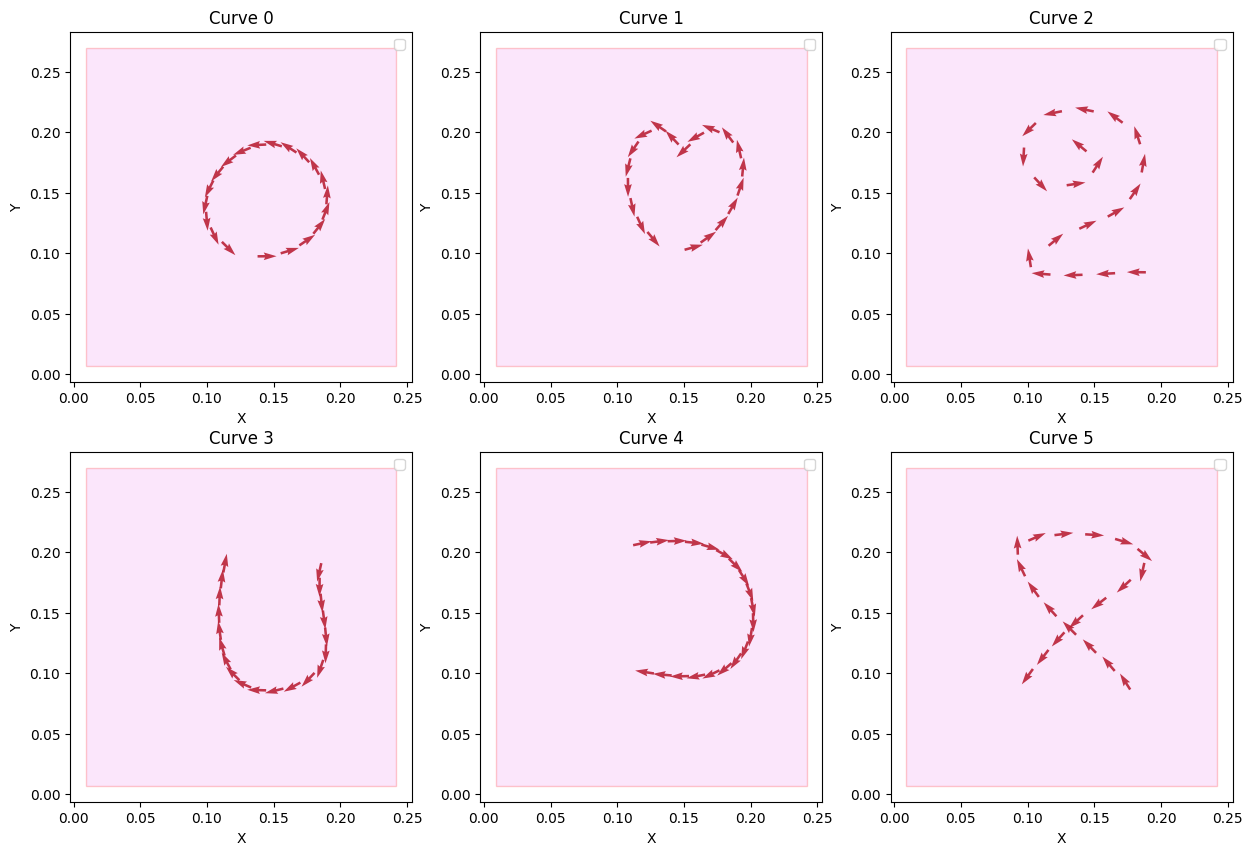

<Figure size 640x480 with 0 Axes>

In [1]:
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data = pkl.load(open('./data/test_traj/test_trajs.pkl', 'rb'))
new_data = {}
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plane_size = np.array([(0.009, 0.034),(0.24200, 0.376)])

x0, x1 = 0.009, 0.242    # Lower-left corner
y0, y1 = 0.27, 0.007   # Upper-right corner
width = x1 - x0
height = y1 - y0
for n, (name, pos) in enumerate(data.items()):
    ax = axes[n]
    ax.quiver(pos[:, 0], pos[:, 1], np.cos(pos[:, 2]), np.sin(pos[:, 2]), color="#aa0000dd")
    ax.legend()
    ax.set_title(f'Curve {n}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='violet', alpha=0.2)
    ax.add_patch(rect)

plt.show()
plt.tight_layout()
plt.show()